In [ ]:
!pip install -q torchinfo mlflow optuna thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 139.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.3 MB/s eta 0:00:00


In [ ]:
import os
import math
import random
from collections import defaultdict, Counter
from typing import List, Optional

import h5py
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
import mlflow
import mlflow.pytorch
import optuna
from optuna.exceptions import TrialPruned
from dotenv import load_dotenv
import time
from thop import profile, clever_format

load_dotenv()

True

In [ ]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/oladipoeyiara@gmail.com/han_sph_ablation_alternate_code_mappings")


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/2727678298130740', creation_time=1767908664414, experiment_id='2727678298130740', last_update_time=1767916356467, lifecycle_stage='active', name='/Users/oladipoeyiara@gmail.com/han_sph_ablation_alternate_code_mappings', tags={'mlflow.experiment.sourceName': '/Users/oladipoeyiara@gmail.com/han_sph_ablation_alternate_code_mappings',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'oladipoeyiara@gmail.com',
 'mlflow.ownerId': '1108839756692281'}>

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)

    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

# Define the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/records.zip'

# Define the extraction path
extract_path = '/content'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Check if the zip file exists
if os.path.exists(zip_file_path):
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Successfully extracted {zip_file_path} to {extract_path}")
else:
    print(f"Error: {zip_file_path} not found.")

Mounted at /content/drive
Successfully extracted /content/drive/MyDrive/records.zip to /content


In [ ]:
# -------------------------
# Config
# -------------------------
PATH = "records"
SAMPLING_RATE = 300
PRE_PEAK_SAMPLES = 99
POST_PEAK_SAMPLES = 201
SEGMENT_LENGTH = PRE_PEAK_SAMPLES + POST_PEAK_SAMPLES  # 300
BATCH_SIZE = 16
DROP_LAST = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# -------------------------
# utilities: filtering and peak detection
# -------------------------
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


def pan_tompkins_detector(ecg_signal, fs):
    lowcut, highcut = 5.0, 15.0
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_ecg = filtfilt(b, a, ecg_signal)
    diff_ecg = np.diff(filtered_ecg)
    squared_ecg = diff_ecg ** 2
    window_size = int(0.150 * fs)
    mwa_ecg = np.convolve(squared_ecg, np.ones(window_size) / window_size, mode='same')
    peaks, _ = find_peaks(mwa_ecg, distance=int(0.6 * fs))
    return peaks


def multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=None):
    n_leads = len(detected_peaks)
    if min_leads is None:
        min_leads = int(np.ceil(n_leads / 2))

    # Collect all peaks with their lead information
    all_peaks = [(p, lead) for lead, peaks in enumerate(detected_peaks) for p in peaks]
    all_peaks.sort(key=lambda x: x[0])

    fused_peaks = []
    i = 0

    while i < len(all_peaks):
        # Start a new cluster
        cluster = [all_peaks[i]]
        i += 1

        # Add nearby peaks to the cluster
        while i < len(all_peaks) and all_peaks[i][0] - cluster[-1][0] <= fusion_window * fs:
            cluster.append(all_peaks[i])
            i += 1

        # Check if cluster has peaks from enough leads
        unique_leads = {lead for _, lead in cluster}
        if len(unique_leads) >= min_leads:
            # Use median position as the fused peak
            fused_peak = int(np.median([p for (p, _) in cluster]))
            fused_peaks.append(fused_peak)

    return np.array(sorted(fused_peaks))


def detect_r_peaks(ecg_signals, fs):
    detected_peaks = []
    for lead in ecg_signals:
        peaks = pan_tompkins_detector(lead, fs)
        detected_peaks.append(peaks)

    fused_r_peaks = multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=6)
    return fused_r_peaks


def extract_segments_around_peaks(signal, r_peaks, pre_samples, post_samples):
    segments = []

    for peak in r_peaks:
        start = max(0, peak - pre_samples)
        end = min(len(signal), peak + post_samples)

        if end - start == pre_samples + post_samples:
            segment = signal[start:end]
            segments.append(segment)

    return segments

def extract_beats_multi_lead(ecg_signals, fs, pre_samples, post_samples, denoise_fn=None):
    # Convert to numpy array for consistent indexing
    ecg_signals = np.array(ecg_signals)

    # Apply denoising if provided
    if denoise_fn is not None:
        ecg_signals = np.array([denoise_fn(lead) for lead in ecg_signals])

    # Detect fused R-peaks across all leads
    r_peaks = detect_r_peaks(ecg_signals, fs)
    # print(f"Detected {len(r_peaks)} R-peaks after fusion")

    if len(r_peaks) == 0:
        return None

    # Extract segments from all leads
    all_lead_segments = []
    for lead_idx, lead_signal in enumerate(ecg_signals):
        segments = extract_segments_around_peaks(lead_signal, r_peaks, pre_samples, post_samples)
        all_lead_segments.append(segments)

    # Find the minimum number of valid segments across all leads
    min_segments = min(len(segments) for segments in all_lead_segments)
    # print(f"Extracted {min_segments} valid segments across all leads")

    if min_segments == 0:
        return None

    # Stack segments: (n_beats, segment_length, n_leads)
    beats_arr = np.stack([
        np.stack(segments[:min_segments], axis=0)
        for segments in all_lead_segments
    ], axis=-1)

    return beats_arr.astype(np.float32)

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from collections import Counter
from joblib import Parallel, delayed
import multiprocessing as mp

# -------------------------
metadata = pd.read_csv("metadata.csv")
codes = pd.read_csv("code_new.csv")

code_mappings = dict(zip(codes['Code'].astype(str), codes['Category']))

metadata = metadata[~metadata['AHA_Code'].str.contains(";")]
metadata['AHA_Code'] = metadata['AHA_Code'].str.split("+").str[0]
metadata['AHA_Code_Mapped'] = metadata['AHA_Code'].map(code_mappings)

unique_labels = sorted(metadata['AHA_Code_Mapped'].dropna().unique())
label2idx = {lbl: i for i, lbl in enumerate(unique_labels)}
num_classes = len(unique_labels)

print("num_classes:", num_classes, "labels:", unique_labels)

def process_row(row):
    ecg_data_path = os.path.join(PATH, row.ECG_ID + ".h5")
    if not os.path.exists(ecg_data_path):
        return None

    label = row.AHA_Code_Mapped
    if pd.isna(label) or label not in label2idx:
        return None

    try:
        with h5py.File(ecg_data_path, 'r') as f:
            ecg = np.array(f['ecg'])
    except Exception as e:
        return None

    beats = extract_beats_multi_lead(
        ecg,
        fs=SAMPLING_RATE,
        pre_samples=PRE_PEAK_SAMPLES,
        post_samples=POST_PEAK_SAMPLES,
        denoise_fn=denoise
    )

    if beats is None:
        return None

    return (beats.astype(np.float32), label2idx[label])

n_jobs = max(1, mp.cpu_count() - 1)

results = Parallel(
    n_jobs=n_jobs,
    backend="loky",
    verbose=10
)(
    delayed(process_row)(row)
    for row in metadata.itertuples(index=False)
)

data_list = [r for r in results if r is not None]

print("Prepared records:", len(data_list))
print("Beat counts distribution:", Counter([x[0].shape[0] for x in data_list]))


num_classes: 11 labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M']


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    1.9s
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    2.0s
[Parallel(n_jobs=11)]: Done  39 tasks      | elapsed:    2.1s
[Parallel(n_jobs=11)]: Done  50 tasks      | elapsed:    2.2s
[Parallel(n_jobs=11)]: Done  63 tasks      | elapsed:    2.4s
[Parallel(n_jobs=11)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=11)]: Batch computation too fast (0.19508193200166563s.) Setting batch_size=2.
[Parallel(n_jobs=11)]: Done  91 tasks      | elapsed:    2.6s
[Parallel(n_jobs=11)]: Done 106 tasks      | elapsed:    2.8s
[Parallel(n_jobs=11)]: Done 136 tasks      | elapsed:    2.9s
[Parallel(n_jobs=11)]: Done 170 tasks      | elapsed:    3.1s
[Parallel(n_jobs=11)]: Done 208 tasks      | elapsed:    3.4s
[Parallel(n_jobs=11)]

Prepared records: 20844
Beat counts distribution: Counter({22: 3111, 23: 2772, 21: 2516, 20: 1922, 24: 1659, 19: 1319, 14: 1039, 18: 889, 15: 857, 25: 702, 16: 670, 17: 660, 26: 468, 27: 424, 13: 349, 28: 345, 29: 243, 30: 168, 32: 94, 31: 92, 33: 78, 34: 69, 36: 60, 35: 55, 37: 47, 38: 31, 39: 17, 40: 17, 42: 16, 43: 15, 41: 13, 44: 11, 48: 11, 45: 10, 47: 9, 50: 9, 46: 9, 57: 6, 64: 5, 58: 5, 52: 5, 53: 4, 51: 4, 54: 4, 49: 4, 69: 3, 56: 2, 70: 2, 67: 2, 60: 2, 98: 2, 55: 2, 66: 1, 143: 1, 102: 1, 87: 1, 95: 1, 65: 1, 73: 1, 84: 1, 71: 1, 78: 1, 75: 1, 72: 1, 61: 1, 80: 1, 74: 1, 63: 1})


[Parallel(n_jobs=11)]: Done 22010 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 22046 out of 22046 | elapsed:  1.5min finished


In [ ]:
print(data_list[2][0].shape), label2idx

(20, 300, 12)


(None,
 {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'J': 8,
  'K': 9,
  'M': 10})

In [ ]:

label_counts = Counter([x[1] for x in data_list])
print(label_counts)

Counter({0: 13903, 1: 2612, 9: 1523, 5: 1334, 3: 527, 2: 490, 6: 185, 7: 165, 10: 56, 4: 26, 8: 23})


In [ ]:
# ---------- Length-bucketing Batch Sampler ----------
class LengthBucketBatchSampler(Sampler):
    def __init__(self,
                 lengths: List[int],
                 batch_size: int,
                 bin_size: Optional[int] = None,
                 shuffle: bool = True,
                 drop_last: bool = False):
        self.lengths = list(lengths)
        self.batch_size = int(batch_size)
        self.bin_size = bin_size
        self.shuffle = shuffle
        self.drop_last = drop_last

        # Build mapping length_key -> list of indices
        self._buckets = defaultdict(list)
        for idx, L in enumerate(self.lengths):
            key = self._length_key(L)
            self._buckets[key].append(idx)

        # Convert to normal dict for iteration; keep keys list stable
        self.bucket_keys = list(self._buckets.keys())

    def _length_key(self, length: int) -> int:
        if self.bin_size is None or self.bin_size <= 0:
            return int(length)   # exact-length bucket
        else:
            return (length // self.bin_size) * self.bin_size

    def __iter__(self):
      # For each epoch, build batches from buckets.
      batches = []
      for key in self.bucket_keys:
          idxs = list(self._buckets[key])
          if len(idxs) < self.batch_size:
              # skip this bucket entirely
              continue
          if self.shuffle:
              random.shuffle(idxs)
          # chunk into batches
          for i in range(0, len(idxs), self.batch_size):
              batch = idxs[i:i + self.batch_size]
              if len(batch) < self.batch_size and self.drop_last:
                  continue
              batches.append(batch)

      if self.shuffle:
          random.shuffle(batches)

      for batch in batches:
          yield batch

    def __len__(self):
      total = 0
      for key in self.bucket_keys:
          n = len(self._buckets[key])
          if n < self.batch_size:
              continue  # Skip small buckets like in __iter__
          if self.drop_last:
              total += n // self.batch_size
          else:
              total += math.ceil(n / self.batch_size)
      return total

In [ ]:
class ECGSegmentDataset(Dataset):
    def __init__(self, data_list):
        # data_list: list of (beats_array (S, T, C), label_idx)
        self.data = data_list
        self.num_beats = [int(x[0].shape[0]) for x in data_list]
        # optionally check that T==SEGMENT_LENGTH for all entries
        for sig, _ in data_list:
            assert sig.shape[1] == SEGMENT_LENGTH, "SEGMENT_LENGTH mismatch"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sig, label = self.data[idx]
        sig_t = torch.as_tensor(sig, dtype=torch.float32)  # (S, T, C)
        return {"signal": sig_t, "label": int(label), "num_beats": int(sig_t.shape[0])}


def collate_by_num_beats(batch):
    s_vals = [item["num_beats"] for item in batch]
    if not all(s == s_vals[0] for s in s_vals):
        raise ValueError("collate_by_num_beats received mixed num_beats in a batch")
    signals = torch.stack([item["signal"] for item in batch], dim=0)  # (B, S, T, C)
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
    return {"signal": signals, "label": labels, "num_beats": torch.tensor(s_vals, dtype=torch.long)}


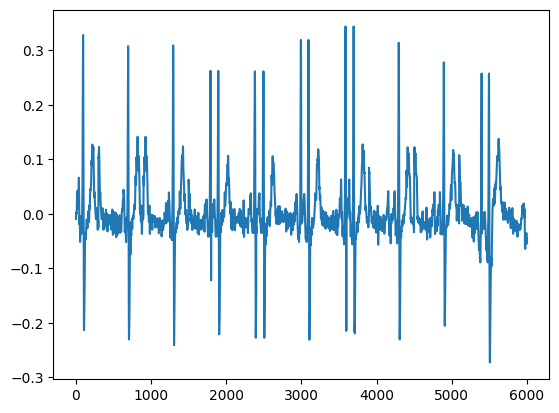

In [ ]:
import matplotlib.pyplot as plt

# Not denoised
plt.plot(np.array(data_list[2][0][:,:,0]).reshape(-1))

In [ ]:
from torch.utils.data import Subset, DataLoader

# # instantiate dataset and sampler
ds = ECGSegmentDataset(data_list)

# -------------------------
# Split indices
# -------------------------
all_indices = list(range(len(ds)))
all_labels = [data_list[i][1] for i in all_indices]  # label_idx for each sample

# First split: train+val vs test (stratified)
trainval_indices, test_indices = train_test_split(
    all_indices,
    test_size=0.1,
    random_state=10,
    stratify=all_labels  
)

# Extract labels for the trainval subset
trainval_labels = [all_labels[i] for i in trainval_indices]

# Second split: train vs val (stratified)
train_indices, val_indices = train_test_split(
    trainval_indices,
    test_size=0.1,
    random_state=10,
    stratify=trainval_labels  
)

# -------------------------
# Create Subsets
# -------------------------
train_ds = Subset(ds, train_indices)
val_ds   = Subset(ds, val_indices)
test_ds  = Subset(ds, test_indices)

# -------------------------
# Make loader helper
# -------------------------
def make_loader(subset_ds, batch_size=16, drop_last=True, shuffle=True):
    subset_indices = subset_ds.indices
    lengths = [ds.num_beats[i] for i in subset_indices]

    sampler = LengthBucketBatchSampler(
        lengths=lengths,
        batch_size=batch_size,
        bin_size=None,       # exact-length buckets
        shuffle=shuffle,
        drop_last=drop_last
    )

    loader = DataLoader(
        subset_ds,
        batch_sampler=sampler,
        collate_fn=collate_by_num_beats,
        num_workers=6,
        pin_memory=True
    )
    return loader


In [ ]:
# Verifying stratifying
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

def get_label_distribution(indices):
    labels = [data_list[i][1] for i in indices]
    return Counter(labels)

print("Train distribution:", get_label_distribution(train_indices))
print("Val distribution:", get_label_distribution(val_indices))
print("Test distribution:", get_label_distribution(test_indices))

Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 8: 2, 4: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


In [ ]:
# -------------------------
# Attention / helper layers
# -------------------------
class ChannelAttention(nn.Module):
    """
    Expects x shape = (batch, channels, seq_len)
    """
    def __init__(self, channels, ratio=8):
        super().__init__()
        mid = max(1, channels // ratio)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=True),
            nn.ReLU(),
            nn.Linear(mid, channels, bias=True)
        )

    def forward(self, x):
        # x: (B, C, L)
        avg_pool = torch.mean(x, dim=2)           # (B, C)
        max_pool, _ = torch.max(x, dim=2)         # (B, C)
        avg_out = self.mlp(avg_pool)              # (B, C)
        max_out = self.mlp(max_pool)              # (B, C)
        att = torch.sigmoid(avg_out + max_out)    # (B, C)
        att = att.unsqueeze(2)                    # (B, C, 1)
        return x * att                             # broadcast multiply -> (B, C, L)


class SegmentAttention(nn.Module):
    """
    Input: (batch, time_steps, input_dim)
    Produces: (batch, input_dim), (batch, time_steps)  (output vector, alphas)
    `units` is the hidden size of the attention MLP (same as original design).
    """
    def __init__(self, input_dim, units):
        super().__init__()
        self.linear = nn.Linear(input_dim, units, bias=True) 
        # u vector for scoring
        self.u = nn.Parameter(torch.randn(units))

    def forward(self, inputs):
        # inputs: (B, T, D)
        v = torch.tanh(self.linear(inputs))           # (B, T, units)
        # score each time step
        vu = torch.matmul(v, self.u)                  # (B, T)
        alphas = F.softmax(vu, dim=1)                 # softmax over time dimension
        output = torch.sum(inputs * alphas.unsqueeze(-1), dim=1)  # (B, D)
        return output, alphas


class TimeDistributedSegmentAttention(nn.Module):
    """
    inputs: (B, segments, seg_len, feature_dim)
    returns: (B, segments, feature_dim), (B, segments, seg_len)
    """
    def __init__(self, input_dim, units):
        super().__init__()
        self.segment_attention = SegmentAttention(input_dim, units)

    def forward(self, inputs):
        # inputs: (B, S, T, D)
        B, S, T, D = inputs.shape
        flat = inputs.view(B * S, T, D)                       # (B*S, T, D)
        outputs, alphas = self.segment_attention(flat)        # (B*S, D), (B*S, T)
        outputs = outputs.view(B, S, D)                       # (B, S, D)
        alphas = alphas.view(B, S, T)                         # (B, S, T)
        return outputs, alphas


class HANWithAttention(nn.Module):
    def __init__(
        self,
        num_classes,
        conv_channels=128,
        segment_hidden=256,
        sequence_hidden=512,
        fc_hidden=2048,
        dropout=0.4,
    ):
        super().__init__()

        # 1D conv over 12 leads
        self.conv1d = nn.Conv1d(12, conv_channels, kernel_size=25, padding=12)
        self.channel_attention = ChannelAttention(conv_channels, ratio=8)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Beat-level LSTM
        self.lstm_segment = nn.LSTM(
            input_size=conv_channels,
            hidden_size=segment_hidden,
            batch_first=True
        )
        self.time_distributed_attention = TimeDistributedSegmentAttention(
            segment_hidden,
            segment_hidden
        )

        # Sequence-level LSTM
        self.lstm_sequence = nn.LSTM(
            input_size=segment_hidden,
            hidden_size=sequence_hidden,
            batch_first=True
        )
        self.final_attention = SegmentAttention(sequence_hidden, sequence_hidden)

        self.fc = nn.Linear(sequence_hidden, fc_hidden)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(fc_hidden, num_classes)

    def forward(self, x):
        logits, _, _ = self.forward_with_attention(x)
        return logits

    def forward_with_attention(self, x):
        # x: (B, S, T, C) = (batch, beats, time, leads)
        B, S, T, C = x.shape

        # process beats individually: (B*S, C, T)
        x = x.view(B * S, T, C).permute(0, 2, 1)

        conv = self.conv1d(x)
        att  = self.channel_attention(conv)
        pooled = self.pool(att).permute(0, 2, 1)     # (B*S, T2, conv_channels)

        seg_out, _ = self.lstm_segment(pooled)       # (B*S, T2, segment_hidden)

        # regroup beats: (B, S, T2, segment_hidden)
        seg_out = seg_out.view(B, S, seg_out.shape[1], seg_out.shape[2])

        # TimeDistributed attention over each beat
        seg_feats, seg_alphas = self.time_distributed_attention(seg_out)  # (B,S,segment_hidden)

        # Sequence-level LSTM over beats
        seq_out, _ = self.lstm_sequence(seg_feats)                        # (B,S,sequence_hidden)
        final_vec, final_alphas = self.final_attention(seq_out)           # (B,sequence_hidden), (B,S)

        x = F.relu(self.fc(final_vec))
        x = self.dropout(x)
        logits = self.classifier(x)                                       # (B,C)
        return logits, final_alphas, seg_alphas

In [ ]:
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HANWithAttention(num_classes=11,
                          conv_channels=128,
                          segment_hidden=128,
                          sequence_hidden=512,
                          fc_hidden=512,
                          dropout=0.3).to(device)

summary(model,
        input_size=(2, 10, 300, 12),    # (batch, segments, timesteps, channels)
        col_names=("input_size", "output_size", "num_params", "trainable"),
        depth=4,
        device=device.type)            # "cpu" or "cuda"


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
HANWithAttention                              [2, 10, 300, 12]          [2, 11]                   --                        True
├─Conv1d: 1-1                                 [20, 12, 300]             [20, 128, 300]            38,528                    True
├─ChannelAttention: 1-2                       [20, 128, 300]            [20, 128, 300]            --                        True
│    └─Sequential: 2-1                        [20, 128]                 [20, 128]                 --                        True
│    │    └─Linear: 3-1                       [20, 128]                 [20, 16]                  2,064                     True
│    │    └─ReLU: 3-2                         [20, 16]                  [20, 16]                  --                        --
│    │    └─Linear: 3-3                       [20, 16]                  [20, 128]             

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from tqdm import tqdm

def evaluate_metrics(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in loader:
            inputs = batch["signal"].to(device)
            labels = batch["label"].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    avg_loss = running_loss / len(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    try:
      y_true = np.eye(num_classes)[all_labels]
      y_score = np.array(all_probs)

      auc_list = []
      for i in range(num_classes):
          if np.any(y_true[:, i]):  # class i exists
              auc_list.append(roc_auc_score(y_true[:, i], y_score[:, i]))
      if auc_list:
          auc = np.mean(auc_list)
      else:
          auc = float("nan")
    except ValueError:
        auc = float("nan")

    return avg_loss, acc, precision, recall, auc, f1

def train(model, train_loader, val_loader, optimizer, criterion, device,
          epochs, scheduler=None):
    model.to(device)
    history = {
        "train_loss": [], "train_acc": [], "train_f1": [], "train_precision": [], "train_recall": [], "train_auc": [],
        "val_loss": [],   "val_acc": [],   "val_f1": [],   "val_precision": [],   "val_recall": [], "val_auc": []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        all_preds = []
        all_probs = []
        all_labels = []
        steps = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for batch in loop:
            inputs = batch["signal"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            correct += (preds == labels).sum().item()
            total += batch_size

            all_preds.extend(preds.cpu().numpy().tolist())
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

            steps += 1
            loop.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(correct/total):.4f}")

        if scheduler is not None:
            try:
                scheduler.step()
            except Exception:
                pass

        # if statement is kinda useless
        if total == 0:
            epoch_loss = float("nan")
            epoch_acc = float("nan")
            epoch_precision = epoch_recall = epoch_f1 = float("nan")
        else:
            epoch_loss = running_loss / total
            epoch_acc = correct / total
            epoch_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
            try:
              y_true = np.eye(num_classes)[all_labels]
              y_score = np.array(all_probs)

              auc_list = []
              for i in range(num_classes):
                  if np.any(y_true[:, i]):
                      auc_list.append(roc_auc_score(y_true[:, i], y_score[:, i]))
              if auc_list:
                  auc = np.mean(auc_list)
              else:
                  auc = float("nan")
            except ValueError:
                auc = float("nan")

        # append train history
        history["train_loss"].append(epoch_loss)
        history["train_auc"].append(auc)
        history["train_acc"].append(epoch_acc)
        history["train_precision"].append(epoch_precision)
        history["train_recall"].append(epoch_recall)
        history["train_f1"].append(epoch_f1)

        print(f"Epoch {epoch}/{epochs}  train_loss: {epoch_loss:.4f}  train_acc: {epoch_acc:.4f}  train_f1: {epoch_f1:.4f}")

        # Validation
        if val_loader is not None:
            vloss, vacc, vprecision, vrecall, vauc, vf1 = evaluate_metrics(model, val_loader, criterion, device)
            history["val_loss"].append(vloss)
            history["val_acc"].append(vacc)
            history["val_auc"].append(vauc)
            history["val_f1"].append(vf1)
            history["val_precision"].append(vprecision)
            history["val_recall"].append(vrecall)


            # log per-epoch metrics to mlflow if available
            if 'mlflow' in globals():
                try:
                    mlflow.log_metric("train_loss", epoch_loss, step=epoch)
                    mlflow.log_metric("train_f1", epoch_f1, step=epoch)
                    mlflow.log_metric("train_precision", epoch_precision, step=epoch)
                    mlflow.log_metric("train_recall", epoch_recall, step=epoch)
                    mlflow.log_metric("train_acc", epoch_acc, step=epoch)
                    mlflow.log_metric("train_auc", auc, step=epoch)

                    mlflow.log_metric("val_loss", vloss, step=epoch)
                    mlflow.log_metric("val_f1", vf1, step=epoch)
                    mlflow.log_metric("val_precision", vprecision, step=epoch)
                    mlflow.log_metric("val_recall", vrecall, step=epoch)
                    mlflow.log_metric("val_acc", vacc, step=epoch)
                    mlflow.log_metric("val_auc", vauc, step=epoch)
                except Exception:
                    pass

            tqdm.write(
                f"Epoch {epoch}  train_loss {epoch_loss:.4f} | val_loss {vloss:.4f} | "
                f"val_f1 {vf1:.4f} | val_precision {vprecision:.4f} | val_recall {vrecall:.4f} | val_auc {vauc:.4f}"
            )
        else:
            # keep consistent history lengths
            history["val_loss"].append(None)
            history["val_auc"].append(None)
            history["val_acc"].append(None)
            history["val_f1"].append(None)
            history["val_precision"].append(None)
            history["val_recall"].append(None)

    return history

# -------------


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from tqdm import tqdm
import random

def run_experiments(model_fn,
                    optimizer_fn, criterion, device, epochs, num_classes,
                    seeds=10):

  results = {"acc": [], "precision": [], "recall": [], "auc": [], "loss": [], "f1": []}
  print("run exp")
  for seed in range(seeds):
      print(f"\n=== Seed {seed} ===")
      set_seed(seed)

      all_indices = list(range(len(ds)))
      all_labels = [data_list[i][1] for i in all_indices]  # label_idx for each sample

      trainval_indices, test_indices = train_test_split(
          all_indices,
          test_size=0.1,
          random_state=seed,
          stratify=all_labels  # ← stratify by class labels
      )

      # Extract labels for the trainval subset
      trainval_labels = [all_labels[i] for i in trainval_indices]

      # Second split: train vs val (stratified)
      train_indices, val_indices = train_test_split(
          trainval_indices,
          test_size=0.1,
          random_state=seed,
          stratify=trainval_labels  # ← stratify by class labels
      )

      # -------------------------
      # Create Subsets
      # -------------------------
      train_ds = Subset(ds, train_indices)
      val_ds   = Subset(ds, val_indices)
      test_ds  = Subset(ds, test_indices)

      train_loader = make_loader(train_ds, batch_size=BATCH_SIZE)
      val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
      test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

      print("Train distribution:", get_label_distribution(train_indices))
      print("Val distribution:", get_label_distribution(val_indices))
      print("Test distribution:", get_label_distribution(test_indices))

      model = model_fn().to(device)
      optimizer = optimizer_fn(model)
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

      # Train
      with mlflow.start_run(nested=True, run_name=f"HAN-SPH-ABL-SEED-{seed}"):
        _ = train(model, train_loader, val_loader, optimizer, criterion, device, epochs, scheduler)

        # Evaluate on test set
        loss, acc, precision, recall, auc, f1 = evaluate_metrics(model, test_loader, criterion, device)

        print(f"Test (seed {seed}) — loss: {loss:.4f}, acc: {acc:.4f}, "
            f"precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, f1: {f1:.4f}")

      results["loss"].append(loss)
      results["acc"].append(acc)
      results["precision"].append(precision)
      results["recall"].append(recall)
      results["auc"].append(auc)
      results["f1"].append(f1)

  # Aggregate results
  print("\n=== Final Results (across seeds) ===")
  for k, v in results.items():
      arr = np.array(v, dtype=np.float32)
      print(f"{k}: mean={arr.mean():.4f}, std={arr.std():.4f}")

  return results


In [ ]:
def model_fn():
  return HANWithAttention(num_classes=num_classes,
                            conv_channels=128,
                            segment_hidden=128,
                            sequence_hidden=512,
                            fc_hidden=512,
                            dropout=0.3)

def optimizer_fn(model):
  return torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=9e-5)


In [ ]:
criterion = nn.CrossEntropyLoss()
run_experiments(model_fn, optimizer_fn, criterion, DEVICE, 25, 11, 10)
# maybe change num of epochs to 30!

run exp

=== Seed 0 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 8: 2, 4: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.2101  train_acc: 0.6697  train_f1: 0.5388
Epoch 1  train_loss 1.2101 | val_loss 1.1414 | val_f1 0.5548 | val_precision 0.4670 | val_recall 0.6834 | val_auc 0.5851


Epoch 2/25  train_loss: 1.0983  train_acc: 0.6742  train_f1: 0.5710
Epoch 2  train_loss 1.0983 | val_loss 0.9845 | val_f1 0.6012 | val_precision 0.6440 | val_recall 0.7075 | val_auc 0.6895


Epoch 3/25  train_loss: 0.9890  train_acc: 0.7055  train_f1: 0.6338
Epoch 3  train_loss 0.9890 | val_loss 0.9125 | val_f1 0.6721 | val_precision 0.6433 | val_recall 0.7229 | val_auc 0.7486


Epoch 4/25  train_loss: 0.8913  train_acc: 0.7370  train_f1: 0.6890
Epoch 4  train_loss 0.8913 | val_loss 0.7699 | val_f1 0.7335 | val_precision 0.7415 | val_recall 0.7718 | val_auc 0.7972


Epoch 5/25  train_loss: 0.7846  train_acc: 0.7619  train_f1: 0.7258
Epoch 5  train_loss 0.7846 | val_loss 0.6906 | val_f1 0.7458 | val_precision 0.7747 | val_recall 0.7866 | val_auc 0.8511


Epoch 6/25  train_loss: 0.6710  train_acc: 0.7917  train_f1: 0.7636
Epoch 6  train_loss 0.6710 | val_loss 0.6552 | val_f1 0.7602 | val_precision 0.7678 | val_recall 0.7907 | val_auc 0.8263


Epoch 7/25  train_loss: 0.6411  train_acc: 0.7975  train_f1: 0.7724
Epoch 7  train_loss 0.6411 | val_loss 0.6780 | val_f1 0.7691 | val_precision 0.7710 | val_recall 0.7883 | val_auc 0.8424


Epoch 8/25  train_loss: 0.6058  train_acc: 0.8026  train_f1: 0.7795
Epoch 8  train_loss 0.6058 | val_loss 0.6256 | val_f1 0.7649 | val_precision 0.7755 | val_recall 0.7948 | val_auc 0.8459


Epoch 9/25  train_loss: 0.5818  train_acc: 0.8078  train_f1: 0.7872
Epoch 9  train_loss 0.5818 | val_loss 0.5944 | val_f1 0.7784 | val_precision 0.7788 | val_recall 0.7995 | val_auc 0.8607


Epoch 10/25  train_loss: 0.5557  train_acc: 0.8135  train_f1: 0.7949
Epoch 10  train_loss 0.5557 | val_loss 0.5845 | val_f1 0.7663 | val_precision 0.7918 | val_recall 0.7989 | val_auc 0.8796


Epoch 11/25  train_loss: 0.4995  train_acc: 0.8316  train_f1: 0.8160
Epoch 11  train_loss 0.4995 | val_loss 0.5428 | val_f1 0.7941 | val_precision 0.7938 | val_recall 0.8149 | val_auc 0.8908


Epoch 12/25  train_loss: 0.4775  train_acc: 0.8355  train_f1: 0.8219
Epoch 12  train_loss 0.4775 | val_loss 0.5388 | val_f1 0.8026 | val_precision 0.8033 | val_recall 0.8154 | val_auc 0.8957


Epoch 13/25  train_loss: 0.4551  train_acc: 0.8423  train_f1: 0.8312
Epoch 13  train_loss 0.4551 | val_loss 0.5410 | val_f1 0.8045 | val_precision 0.8063 | val_recall 0.8184 | val_auc 0.9007


Epoch 14/25  train_loss: 0.4474  train_acc: 0.8490  train_f1: 0.8387
Epoch 14  train_loss 0.4474 | val_loss 0.5180 | val_f1 0.8145 | val_precision 0.8118 | val_recall 0.8272 | val_auc 0.9011


Epoch 15/25  train_loss: 0.4280  train_acc: 0.8516  train_f1: 0.8429
Epoch 15  train_loss 0.4280 | val_loss 0.5067 | val_f1 0.8092 | val_precision 0.8099 | val_recall 0.8225 | val_auc 0.9101


Epoch 16/25  train_loss: 0.3837  train_acc: 0.8684  train_f1: 0.8612
Epoch 16  train_loss 0.3837 | val_loss 0.5277 | val_f1 0.8235 | val_precision 0.8245 | val_recall 0.8337 | val_auc 0.9192


Epoch 17/25  train_loss: 0.3661  train_acc: 0.8724  train_f1: 0.8656
Epoch 17  train_loss 0.3661 | val_loss 0.5292 | val_f1 0.8225 | val_precision 0.8207 | val_recall 0.8314 | val_auc 0.9144


Epoch 18/25  train_loss: 0.3568  train_acc: 0.8756  train_f1: 0.8701
Epoch 18  train_loss 0.3568 | val_loss 0.5266 | val_f1 0.8280 | val_precision 0.8276 | val_recall 0.8355 | val_auc 0.9141


Epoch 19/25  train_loss: 0.3432  train_acc: 0.8805  train_f1: 0.8754
Epoch 19  train_loss 0.3432 | val_loss 0.5260 | val_f1 0.8216 | val_precision 0.8187 | val_recall 0.8296 | val_auc 0.9174


Epoch 20/25  train_loss: 0.3301  train_acc: 0.8860  train_f1: 0.8808
Epoch 20  train_loss 0.3301 | val_loss 0.5380 | val_f1 0.8279 | val_precision 0.8310 | val_recall 0.8355 | val_auc 0.9230


Epoch 21/25  train_loss: 0.2941  train_acc: 0.9004  train_f1: 0.8968
Epoch 21  train_loss 0.2941 | val_loss 0.5613 | val_f1 0.8214 | val_precision 0.8217 | val_recall 0.8272 | val_auc 0.9224


Epoch 22/25  train_loss: 0.2821  train_acc: 0.9036  train_f1: 0.9002
Epoch 22  train_loss 0.2821 | val_loss 0.5552 | val_f1 0.8245 | val_precision 0.8226 | val_recall 0.8302 | val_auc 0.9248


Epoch 23/25  train_loss: 0.2717  train_acc: 0.9080  train_f1: 0.9049
Epoch 23  train_loss 0.2717 | val_loss 0.5793 | val_f1 0.8192 | val_precision 0.8174 | val_recall 0.8243 | val_auc 0.9297


Epoch 24/25  train_loss: 0.2606  train_acc: 0.9118  train_f1: 0.9089
Epoch 24  train_loss 0.2606 | val_loss 0.5770 | val_f1 0.8195 | val_precision 0.8200 | val_recall 0.8231 | val_auc 0.9227


Epoch 25/25  train_loss: 0.2499  train_acc: 0.9168  train_f1: 0.9141
Epoch 25  train_loss 0.2499 | val_loss 0.5969 | val_f1 0.8160 | val_precision 0.8147 | val_recall 0.8213 | val_auc 0.9227
Test (seed 0) — loss: 0.5425, acc: 0.8464, precision: 0.8380, recall: 0.8464, auc: 0.8864, f1: 0.8405
🏃 View run HAN-SPH-ABL-SEED-0 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/b69fd84bbc234bcbb9b97892f55dc2b7
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 1 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 4: 2, 8: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.1999  train_acc: 0.6707  train_f1: 0.5448
Epoch 1  train_loss 1.1999 | val_loss 1.1019 | val_f1 0.5362 | val_precision 0.4474 | val_recall 0.6689 | val_auc 0.7141


Epoch 2/25  train_loss: 1.0641  train_acc: 0.6872  train_f1: 0.6041
Epoch 2  train_loss 1.0641 | val_loss 0.9631 | val_f1 0.6689 | val_precision 0.6802 | val_recall 0.7194 | val_auc 0.7525


Epoch 3/25  train_loss: 0.8936  train_acc: 0.7249  train_f1: 0.6741
Epoch 3  train_loss 0.8936 | val_loss 0.8112 | val_f1 0.7026 | val_precision 0.6962 | val_recall 0.7416 | val_auc 0.8156


Epoch 4/25  train_loss: 0.8087  train_acc: 0.7496  train_f1: 0.7053
Epoch 4  train_loss 0.8087 | val_loss 0.7653 | val_f1 0.7086 | val_precision 0.7203 | val_recall 0.7632 | val_auc 0.8498


Epoch 5/25  train_loss: 0.7753  train_acc: 0.7625  train_f1: 0.7212
Epoch 5  train_loss 0.7753 | val_loss 0.7635 | val_f1 0.7208 | val_precision 0.7421 | val_recall 0.7584 | val_auc 0.8694


Epoch 6/25  train_loss: 0.6911  train_acc: 0.7806  train_f1: 0.7469
Epoch 6  train_loss 0.6911 | val_loss 0.6585 | val_f1 0.7680 | val_precision 0.7609 | val_recall 0.7885 | val_auc 0.8985


Epoch 7/25  train_loss: 0.6503  train_acc: 0.7944  train_f1: 0.7654
Epoch 7  train_loss 0.6503 | val_loss 0.5953 | val_f1 0.7781 | val_precision 0.7730 | val_recall 0.7999 | val_auc 0.8920


Epoch 8/25  train_loss: 0.6146  train_acc: 0.7988  train_f1: 0.7731
Epoch 8  train_loss 0.6146 | val_loss 0.6111 | val_f1 0.7719 | val_precision 0.7756 | val_recall 0.7987 | val_auc 0.9142


Epoch 9/25  train_loss: 0.5976  train_acc: 0.8057  train_f1: 0.7831
Epoch 9  train_loss 0.5976 | val_loss 0.5786 | val_f1 0.7790 | val_precision 0.7987 | val_recall 0.8089 | val_auc 0.9058


Epoch 10/25  train_loss: 0.5687  train_acc: 0.8138  train_f1: 0.7932
Epoch 10  train_loss 0.5687 | val_loss 0.5507 | val_f1 0.7954 | val_precision 0.8032 | val_recall 0.8173 | val_auc 0.9259


Epoch 11/25  train_loss: 0.5166  train_acc: 0.8254  train_f1: 0.8086
Epoch 11  train_loss 0.5166 | val_loss 0.5393 | val_f1 0.8000 | val_precision 0.8075 | val_recall 0.8173 | val_auc 0.9205


Epoch 12/25  train_loss: 0.4966  train_acc: 0.8323  train_f1: 0.8179
Epoch 12  train_loss 0.4966 | val_loss 0.5425 | val_f1 0.7787 | val_precision 0.7835 | val_recall 0.7999 | val_auc 0.9237


Epoch 13/25  train_loss: 0.4821  train_acc: 0.8352  train_f1: 0.8220
Epoch 13  train_loss 0.4821 | val_loss 0.5149 | val_f1 0.8072 | val_precision 0.8153 | val_recall 0.8227 | val_auc 0.9210


Epoch 14/25  train_loss: 0.4650  train_acc: 0.8427  train_f1: 0.8306
Epoch 14  train_loss 0.4650 | val_loss 0.5134 | val_f1 0.8059 | val_precision 0.8165 | val_recall 0.8251 | val_auc 0.9234


Epoch 15/25  train_loss: 0.4481  train_acc: 0.8442  train_f1: 0.8332
Epoch 15  train_loss 0.4481 | val_loss 0.5051 | val_f1 0.8234 | val_precision 0.8222 | val_recall 0.8353 | val_auc 0.9270


Epoch 16/25  train_loss: 0.4080  train_acc: 0.8591  train_f1: 0.8503
Epoch 16  train_loss 0.4080 | val_loss 0.5030 | val_f1 0.8166 | val_precision 0.8194 | val_recall 0.8305 | val_auc 0.9177


Epoch 17/25  train_loss: 0.3868  train_acc: 0.8677  train_f1: 0.8603
Epoch 17  train_loss 0.3868 | val_loss 0.5009 | val_f1 0.8212 | val_precision 0.8195 | val_recall 0.8323 | val_auc 0.9323


Epoch 18/25  train_loss: 0.3759  train_acc: 0.8708  train_f1: 0.8636
Epoch 18  train_loss 0.3759 | val_loss 0.5140 | val_f1 0.8167 | val_precision 0.8176 | val_recall 0.8287 | val_auc 0.9303


Epoch 19/25  train_loss: 0.3631  train_acc: 0.8777  train_f1: 0.8716
Epoch 19  train_loss 0.3631 | val_loss 0.4986 | val_f1 0.8255 | val_precision 0.8222 | val_recall 0.8335 | val_auc 0.9294


Epoch 20/25  train_loss: 0.3522  train_acc: 0.8798  train_f1: 0.8741
Epoch 20  train_loss 0.3522 | val_loss 0.5050 | val_f1 0.8192 | val_precision 0.8211 | val_recall 0.8311 | val_auc 0.9324


Epoch 21/25  train_loss: 0.3166  train_acc: 0.8925  train_f1: 0.8872
Epoch 21  train_loss 0.3166 | val_loss 0.5236 | val_f1 0.8191 | val_precision 0.8207 | val_recall 0.8281 | val_auc 0.9365


Epoch 22/25  train_loss: 0.3058  train_acc: 0.8960  train_f1: 0.8917
Epoch 22  train_loss 0.3058 | val_loss 0.5180 | val_f1 0.8231 | val_precision 0.8219 | val_recall 0.8329 | val_auc 0.9396


Epoch 23/25  train_loss: 0.2932  train_acc: 0.9016  train_f1: 0.8976
Epoch 23  train_loss 0.2932 | val_loss 0.5245 | val_f1 0.8195 | val_precision 0.8194 | val_recall 0.8305 | val_auc 0.9443


Epoch 24/25  train_loss: 0.2823  train_acc: 0.9048  train_f1: 0.9012
Epoch 24  train_loss 0.2823 | val_loss 0.5417 | val_f1 0.8108 | val_precision 0.8081 | val_recall 0.8179 | val_auc 0.9233


Epoch 25/25  train_loss: 0.2704  train_acc: 0.9089  train_f1: 0.9058
Epoch 25  train_loss 0.2704 | val_loss 0.5413 | val_f1 0.8205 | val_precision 0.8185 | val_recall 0.8269 | val_auc 0.9392
Test (seed 1) — loss: 0.6467, acc: 0.8098, precision: 0.7984, recall: 0.8098, auc: 0.8627, f1: 0.8019
🏃 View run HAN-SPH-ABL-SEED-1 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/93e40425d88147a7a8ec39576aac6e74
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 2 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 8: 2, 4: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.1774  train_acc: 0.6750  train_f1: 0.5573
Epoch 1  train_loss 1.1774 | val_loss 1.0676 | val_f1 0.5593 | val_precision 0.5044 | val_recall 0.6792 | val_auc 0.6438


Epoch 2/25  train_loss: 0.9889  train_acc: 0.7040  train_f1: 0.6174
Epoch 2  train_loss 0.9889 | val_loss 0.8780 | val_f1 0.6547 | val_precision 0.6487 | val_recall 0.7170 | val_auc 0.7647


Epoch 3/25  train_loss: 0.8641  train_acc: 0.7338  train_f1: 0.6755
Epoch 3  train_loss 0.8641 | val_loss 0.7853 | val_f1 0.7098 | val_precision 0.7058 | val_recall 0.7500 | val_auc 0.8279


Epoch 4/25  train_loss: 0.7975  train_acc: 0.7517  train_f1: 0.7083
Epoch 4  train_loss 0.7975 | val_loss 0.7694 | val_f1 0.7296 | val_precision 0.7430 | val_recall 0.7476 | val_auc 0.8293


Epoch 5/25  train_loss: 0.7419  train_acc: 0.7657  train_f1: 0.7293
Epoch 5  train_loss 0.7419 | val_loss 0.6814 | val_f1 0.7263 | val_precision 0.7716 | val_recall 0.7754 | val_auc 0.8506


Epoch 6/25  train_loss: 0.6513  train_acc: 0.7882  train_f1: 0.7577
Epoch 6  train_loss 0.6513 | val_loss 0.6316 | val_f1 0.7646 | val_precision 0.7819 | val_recall 0.7907 | val_auc 0.8779


Epoch 7/25  train_loss: 0.6239  train_acc: 0.7986  train_f1: 0.7711
Epoch 7  train_loss 0.6239 | val_loss 0.6137 | val_f1 0.7672 | val_precision 0.7891 | val_recall 0.7966 | val_auc 0.8713


Epoch 8/25  train_loss: 0.6011  train_acc: 0.8026  train_f1: 0.7784
Epoch 8  train_loss 0.6011 | val_loss 0.6255 | val_f1 0.7657 | val_precision 0.7858 | val_recall 0.7930 | val_auc 0.8823


Epoch 9/25  train_loss: 0.5818  train_acc: 0.8071  train_f1: 0.7840
Epoch 9  train_loss 0.5818 | val_loss 0.6100 | val_f1 0.7840 | val_precision 0.7906 | val_recall 0.8084 | val_auc 0.8741


Epoch 10/25  train_loss: 0.5622  train_acc: 0.8127  train_f1: 0.7930
Epoch 10  train_loss 0.5622 | val_loss 0.6395 | val_f1 0.7716 | val_precision 0.7918 | val_recall 0.7995 | val_auc 0.8802


Epoch 11/25  train_loss: 0.5082  train_acc: 0.8266  train_f1: 0.8109
Epoch 11  train_loss 0.5082 | val_loss 0.5718 | val_f1 0.7949 | val_precision 0.7954 | val_recall 0.8119 | val_auc 0.8760


Epoch 12/25  train_loss: 0.4826  train_acc: 0.8334  train_f1: 0.8206
Epoch 12  train_loss 0.4826 | val_loss 0.5838 | val_f1 0.7882 | val_precision 0.7850 | val_recall 0.8078 | val_auc 0.8850


Epoch 13/25  train_loss: 0.4636  train_acc: 0.8409  train_f1: 0.8290
Epoch 13  train_loss 0.4636 | val_loss 0.5438 | val_f1 0.8028 | val_precision 0.8008 | val_recall 0.8178 | val_auc 0.9107


Epoch 14/25  train_loss: 0.4477  train_acc: 0.8462  train_f1: 0.8360
Epoch 14  train_loss 0.4477 | val_loss 0.5514 | val_f1 0.7989 | val_precision 0.7929 | val_recall 0.8090 | val_auc 0.8888


Epoch 15/25  train_loss: 0.4303  train_acc: 0.8519  train_f1: 0.8432
Epoch 15  train_loss 0.4303 | val_loss 0.5409 | val_f1 0.7957 | val_precision 0.7949 | val_recall 0.8113 | val_auc 0.9004


Epoch 16/25  train_loss: 0.3805  train_acc: 0.8680  train_f1: 0.8614
Epoch 16  train_loss 0.3805 | val_loss 0.5487 | val_f1 0.8106 | val_precision 0.8071 | val_recall 0.8213 | val_auc 0.8938


Epoch 17/25  train_loss: 0.3615  train_acc: 0.8744  train_f1: 0.8689
Epoch 17  train_loss 0.3615 | val_loss 0.5617 | val_f1 0.8032 | val_precision 0.8026 | val_recall 0.8137 | val_auc 0.9067


Epoch 18/25  train_loss: 0.3427  train_acc: 0.8838  train_f1: 0.8794
Epoch 18  train_loss 0.3427 | val_loss 0.5740 | val_f1 0.8101 | val_precision 0.8086 | val_recall 0.8190 | val_auc 0.9008


Epoch 19/25  train_loss: 0.3296  train_acc: 0.8847  train_f1: 0.8805
Epoch 19  train_loss 0.3296 | val_loss 0.5767 | val_f1 0.8082 | val_precision 0.8072 | val_recall 0.8208 | val_auc 0.8997


Epoch 20/25  train_loss: 0.3134  train_acc: 0.8916  train_f1: 0.8881
Epoch 20  train_loss 0.3134 | val_loss 0.5731 | val_f1 0.8159 | val_precision 0.8141 | val_recall 0.8208 | val_auc 0.8969


Epoch 21/25  train_loss: 0.2726  train_acc: 0.9079  train_f1: 0.9053
Epoch 21  train_loss 0.2726 | val_loss 0.6065 | val_f1 0.8100 | val_precision 0.8079 | val_recall 0.8166 | val_auc 0.9184


Epoch 22/25  train_loss: 0.2533  train_acc: 0.9181  train_f1: 0.9163
Epoch 22  train_loss 0.2533 | val_loss 0.6270 | val_f1 0.8081 | val_precision 0.8070 | val_recall 0.8160 | val_auc 0.9177


Epoch 23/25  train_loss: 0.2402  train_acc: 0.9207  train_f1: 0.9190
Epoch 23  train_loss 0.2402 | val_loss 0.6404 | val_f1 0.8050 | val_precision 0.8029 | val_recall 0.8143 | val_auc 0.9210


Epoch 24/25  train_loss: 0.2287  train_acc: 0.9221  train_f1: 0.9206
Epoch 24  train_loss 0.2287 | val_loss 0.6674 | val_f1 0.8059 | val_precision 0.8042 | val_recall 0.8143 | val_auc 0.9164


Epoch 25/25  train_loss: 0.2125  train_acc: 0.9282  train_f1: 0.9268
Epoch 25  train_loss 0.2125 | val_loss 0.7051 | val_f1 0.8109 | val_precision 0.8072 | val_recall 0.8166 | val_auc 0.9137
Test (seed 2) — loss: 0.6838, acc: 0.8199, precision: 0.8128, recall: 0.8199, auc: 0.8849, f1: 0.8137
🏃 View run HAN-SPH-ABL-SEED-2 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/38152776850c4cd09cd9f3f7885fa80c
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 3 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 4: 2, 8: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.2605  train_acc: 0.6685  train_f1: 0.5392
Epoch 1  train_loss 1.2605 | val_loss 1.1843 | val_f1 0.5381 | val_precision 0.4494 | val_recall 0.6704 | val_auc 0.5410


Epoch 2/25  train_loss: 1.1882  train_acc: 0.6711  train_f1: 0.5391
Epoch 2  train_loss 1.1882 | val_loss 1.1519 | val_f1 0.5381 | val_precision 0.4494 | val_recall 0.6704 | val_auc 0.6031


Epoch 3/25  train_loss: 1.1660  train_acc: 0.6718  train_f1: 0.5399
Epoch 3  train_loss 1.1660 | val_loss 1.1357 | val_f1 0.5381 | val_precision 0.4494 | val_recall 0.6704 | val_auc 0.6490


Epoch 4/25  train_loss: 1.1579  train_acc: 0.6715  train_f1: 0.5395
Epoch 4  train_loss 1.1579 | val_loss 1.1383 | val_f1 0.5381 | val_precision 0.4494 | val_recall 0.6704 | val_auc 0.6273


Epoch 5/25  train_loss: 1.1430  train_acc: 0.6717  train_f1: 0.5401
Epoch 5  train_loss 1.1430 | val_loss 1.1238 | val_f1 0.5381 | val_precision 0.4494 | val_recall 0.6704 | val_auc 0.6662


Epoch 6/25  train_loss: 1.1089  train_acc: 0.6710  train_f1: 0.5409
Epoch 6  train_loss 1.1089 | val_loss 1.0892 | val_f1 0.5381 | val_precision 0.4494 | val_recall 0.6704 | val_auc 0.6862


Epoch 7/25  train_loss: 1.0924  train_acc: 0.6724  train_f1: 0.5491
Epoch 7  train_loss 1.0924 | val_loss 1.0793 | val_f1 0.5699 | val_precision 0.5673 | val_recall 0.6722 | val_auc 0.6859


Epoch 8/25  train_loss: 1.0714  train_acc: 0.6757  train_f1: 0.5683
Epoch 8  train_loss 1.0714 | val_loss 1.0320 | val_f1 0.5881 | val_precision 0.6533 | val_recall 0.6869 | val_auc 0.6956


Epoch 9/25  train_loss: 1.0132  train_acc: 0.6902  train_f1: 0.6114
Epoch 9  train_loss 1.0132 | val_loss 0.9587 | val_f1 0.6382 | val_precision 0.6584 | val_recall 0.7075 | val_auc 0.7194


Epoch 10/25  train_loss: 0.9495  train_acc: 0.7104  train_f1: 0.6475
Epoch 10  train_loss 0.9495 | val_loss 0.8957 | val_f1 0.6742 | val_precision 0.7009 | val_recall 0.7341 | val_auc 0.7473


Epoch 11/25  train_loss: 0.7994  train_acc: 0.7552  train_f1: 0.7168
Epoch 11  train_loss 0.7994 | val_loss 0.7805 | val_f1 0.7342 | val_precision 0.7409 | val_recall 0.7671 | val_auc 0.7797


Epoch 12/25  train_loss: 0.7397  train_acc: 0.7719  train_f1: 0.7424
Epoch 12  train_loss 0.7397 | val_loss 0.7430 | val_f1 0.7382 | val_precision 0.7547 | val_recall 0.7742 | val_auc 0.8199


Epoch 13/25  train_loss: 0.7019  train_acc: 0.7815  train_f1: 0.7542
Epoch 13  train_loss 0.7019 | val_loss 0.7176 | val_f1 0.7452 | val_precision 0.7510 | val_recall 0.7771 | val_auc 0.8062


Epoch 14/25  train_loss: 0.6621  train_acc: 0.7913  train_f1: 0.7675
Epoch 14  train_loss 0.6621 | val_loss 0.6805 | val_f1 0.7582 | val_precision 0.7597 | val_recall 0.7854 | val_auc 0.8171


Epoch 15/25  train_loss: 0.6372  train_acc: 0.7929  train_f1: 0.7699
Epoch 15  train_loss 0.6372 | val_loss 0.6867 | val_f1 0.7523 | val_precision 0.7504 | val_recall 0.7718 | val_auc 0.8289


Epoch 16/25  train_loss: 0.5744  train_acc: 0.8121  train_f1: 0.7945
Epoch 16  train_loss 0.5744 | val_loss 0.6602 | val_f1 0.7621 | val_precision 0.7628 | val_recall 0.7824 | val_auc 0.8525


Epoch 17/25  train_loss: 0.5514  train_acc: 0.8149  train_f1: 0.7984
Epoch 17  train_loss 0.5514 | val_loss 0.6486 | val_f1 0.7750 | val_precision 0.7791 | val_recall 0.7913 | val_auc 0.8542


Epoch 18/25  train_loss: 0.5281  train_acc: 0.8214  train_f1: 0.8074
Epoch 18  train_loss 0.5281 | val_loss 0.6250 | val_f1 0.7693 | val_precision 0.7843 | val_recall 0.7930 | val_auc 0.9026


Epoch 19/25  train_loss: 0.5064  train_acc: 0.8286  train_f1: 0.8164
Epoch 19  train_loss 0.5064 | val_loss 0.6264 | val_f1 0.7842 | val_precision 0.7934 | val_recall 0.8007 | val_auc 0.8794


Epoch 20/25  train_loss: 0.4916  train_acc: 0.8335  train_f1: 0.8217
Epoch 20  train_loss 0.4916 | val_loss 0.6148 | val_f1 0.7901 | val_precision 0.7998 | val_recall 0.8096 | val_auc 0.8924


Epoch 21/25  train_loss: 0.4426  train_acc: 0.8441  train_f1: 0.8350
Epoch 21  train_loss 0.4426 | val_loss 0.6008 | val_f1 0.7944 | val_precision 0.7964 | val_recall 0.8096 | val_auc 0.9154


Epoch 22/25  train_loss: 0.4252  train_acc: 0.8517  train_f1: 0.8437
Epoch 22  train_loss 0.4252 | val_loss 0.5987 | val_f1 0.7965 | val_precision 0.7961 | val_recall 0.8072 | val_auc 0.9097


Epoch 23/25  train_loss: 0.4136  train_acc: 0.8548  train_f1: 0.8471
Epoch 23  train_loss 0.4136 | val_loss 0.6078 | val_f1 0.7913 | val_precision 0.7949 | val_recall 0.8054 | val_auc 0.9154


Epoch 24/25  train_loss: 0.3951  train_acc: 0.8597  train_f1: 0.8527
Epoch 24  train_loss 0.3951 | val_loss 0.6040 | val_f1 0.7957 | val_precision 0.7936 | val_recall 0.8072 | val_auc 0.9185


Epoch 25/25  train_loss: 0.3859  train_acc: 0.8618  train_f1: 0.8553
Epoch 25  train_loss 0.3859 | val_loss 0.6086 | val_f1 0.7944 | val_precision 0.7916 | val_recall 0.8007 | val_auc 0.9091
Test (seed 3) — loss: 0.5424, acc: 0.8280, precision: 0.8189, recall: 0.8280, auc: 0.8939, f1: 0.8219
🏃 View run HAN-SPH-ABL-SEED-3 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/a0d8ef81651b41c88d49a6101bfcb0a0
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 4 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 4: 2, 8: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.1152  train_acc: 0.6794  train_f1: 0.5789
Epoch 1  train_loss 1.1152 | val_loss 0.9968 | val_f1 0.5857 | val_precision 0.5480 | val_recall 0.6987 | val_auc 0.7024


Epoch 2/25  train_loss: 0.8987  train_acc: 0.7231  train_f1: 0.6669
Epoch 2  train_loss 0.8987 | val_loss 0.8613 | val_f1 0.6560 | val_precision 0.7280 | val_recall 0.7258 | val_auc 0.8213


Epoch 3/25  train_loss: 0.8248  train_acc: 0.7483  train_f1: 0.7037
Epoch 3  train_loss 0.8248 | val_loss 0.7724 | val_f1 0.7209 | val_precision 0.7255 | val_recall 0.7594 | val_auc 0.8484


Epoch 4/25  train_loss: 0.7774  train_acc: 0.7615  train_f1: 0.7201
Epoch 4  train_loss 0.7774 | val_loss 0.7765 | val_f1 0.7345 | val_precision 0.7451 | val_recall 0.7636 | val_auc 0.8662


Epoch 5/25  train_loss: 0.7585  train_acc: 0.7678  train_f1: 0.7285
Epoch 5  train_loss 0.7585 | val_loss 0.7974 | val_f1 0.7221 | val_precision 0.7349 | val_recall 0.7518 | val_auc 0.8683


Epoch 6/25  train_loss: 0.6874  train_acc: 0.7836  train_f1: 0.7505
Epoch 6  train_loss 0.6874 | val_loss 0.6945 | val_f1 0.7457 | val_precision 0.7955 | val_recall 0.7877 | val_auc 0.8786


Epoch 7/25  train_loss: 0.6557  train_acc: 0.7925  train_f1: 0.7633
Epoch 7  train_loss 0.6557 | val_loss 0.6618 | val_f1 0.7649 | val_precision 0.7755 | val_recall 0.7960 | val_auc 0.8857


Epoch 8/25  train_loss: 0.6224  train_acc: 0.7983  train_f1: 0.7744
Epoch 8  train_loss 0.6224 | val_loss 0.6228 | val_f1 0.7676 | val_precision 0.7776 | val_recall 0.7972 | val_auc 0.9132


Epoch 9/25  train_loss: 0.6018  train_acc: 0.8035  train_f1: 0.7822
Epoch 9  train_loss 0.6018 | val_loss 0.6094 | val_f1 0.7690 | val_precision 0.7748 | val_recall 0.7960 | val_auc 0.9190


Epoch 10/25  train_loss: 0.5773  train_acc: 0.8112  train_f1: 0.7931
Epoch 10  train_loss 0.5773 | val_loss 0.6036 | val_f1 0.7742 | val_precision 0.7817 | val_recall 0.8019 | val_auc 0.9159


Epoch 11/25  train_loss: 0.5279  train_acc: 0.8253  train_f1: 0.8096
Epoch 11  train_loss 0.5279 | val_loss 0.5512 | val_f1 0.7930 | val_precision 0.8030 | val_recall 0.8149 | val_auc 0.9396


Epoch 12/25  train_loss: 0.5085  train_acc: 0.8283  train_f1: 0.8136
Epoch 12  train_loss 0.5085 | val_loss 0.5595 | val_f1 0.7947 | val_precision 0.7994 | val_recall 0.8143 | val_auc 0.9366


Epoch 13/25  train_loss: 0.4910  train_acc: 0.8358  train_f1: 0.8231
Epoch 13  train_loss 0.4910 | val_loss 0.5408 | val_f1 0.8042 | val_precision 0.7993 | val_recall 0.8219 | val_auc 0.9173


Epoch 14/25  train_loss: 0.4800  train_acc: 0.8354  train_f1: 0.8234
Epoch 14  train_loss 0.4800 | val_loss 0.5433 | val_f1 0.8023 | val_precision 0.8064 | val_recall 0.8243 | val_auc 0.9462


Epoch 15/25  train_loss: 0.4672  train_acc: 0.8410  train_f1: 0.8299
Epoch 15  train_loss 0.4672 | val_loss 0.5339 | val_f1 0.7966 | val_precision 0.8044 | val_recall 0.8160 | val_auc 0.9040


Epoch 16/25  train_loss: 0.4307  train_acc: 0.8519  train_f1: 0.8431
Epoch 16  train_loss 0.4307 | val_loss 0.5275 | val_f1 0.8160 | val_precision 0.8152 | val_recall 0.8284 | val_auc 0.9201


Epoch 17/25  train_loss: 0.4122  train_acc: 0.8569  train_f1: 0.8486
Epoch 17  train_loss 0.4122 | val_loss 0.5376 | val_f1 0.8096 | val_precision 0.8103 | val_recall 0.8208 | val_auc 0.9134


Epoch 18/25  train_loss: 0.4015  train_acc: 0.8603  train_f1: 0.8529
Epoch 18  train_loss 0.4015 | val_loss 0.5326 | val_f1 0.8069 | val_precision 0.8044 | val_recall 0.8208 | val_auc 0.9017


Epoch 19/25  train_loss: 0.3852  train_acc: 0.8654  train_f1: 0.8586
Epoch 19  train_loss 0.3852 | val_loss 0.5391 | val_f1 0.8066 | val_precision 0.7992 | val_recall 0.8202 | val_auc 0.8979


Epoch 20/25  train_loss: 0.3717  train_acc: 0.8719  train_f1: 0.8658
Epoch 20  train_loss 0.3717 | val_loss 0.5279 | val_f1 0.8181 | val_precision 0.8197 | val_recall 0.8302 | val_auc 0.9476


Epoch 21/25  train_loss: 0.3418  train_acc: 0.8806  train_f1: 0.8756
Epoch 21  train_loss 0.3418 | val_loss 0.5410 | val_f1 0.8070 | val_precision 0.8064 | val_recall 0.8196 | val_auc 0.9504


Epoch 22/25  train_loss: 0.3261  train_acc: 0.8891  train_f1: 0.8846
Epoch 22  train_loss 0.3261 | val_loss 0.5510 | val_f1 0.8082 | val_precision 0.8094 | val_recall 0.8154 | val_auc 0.9017


Epoch 23/25  train_loss: 0.3159  train_acc: 0.8899  train_f1: 0.8857
Epoch 23  train_loss 0.3159 | val_loss 0.5589 | val_f1 0.8053 | val_precision 0.8044 | val_recall 0.8149 | val_auc 0.9161


Epoch 24/25  train_loss: 0.3035  train_acc: 0.8965  train_f1: 0.8926
Epoch 24  train_loss 0.3035 | val_loss 0.5775 | val_f1 0.8047 | val_precision 0.8044 | val_recall 0.8143 | val_auc 0.8993


Epoch 25/25  train_loss: 0.2942  train_acc: 0.8974  train_f1: 0.8938
Epoch 25  train_loss 0.2942 | val_loss 0.5819 | val_f1 0.8001 | val_precision 0.7976 | val_recall 0.8119 | val_auc 0.9402
Test (seed 4) — loss: 0.5764, acc: 0.8304, precision: 0.8235, recall: 0.8304, auc: 0.9049, f1: 0.8231
🏃 View run HAN-SPH-ABL-SEED-4 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/a2f3093b8fe647ae97644fa8663c3ffa
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 5 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 8: 2, 4: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.1801  train_acc: 0.6745  train_f1: 0.5514
Epoch 1  train_loss 1.1801 | val_loss 1.0875 | val_f1 0.5863 | val_precision 0.5103 | val_recall 0.6964 | val_auc 0.7240


Epoch 2/25  train_loss: 1.0306  train_acc: 0.6989  train_f1: 0.6050
Epoch 2  train_loss 1.0306 | val_loss 0.8921 | val_f1 0.6620 | val_precision 0.6103 | val_recall 0.7393 | val_auc 0.7732


Epoch 3/25  train_loss: 0.8719  train_acc: 0.7384  train_f1: 0.6654
Epoch 3  train_loss 0.8719 | val_loss 0.8790 | val_f1 0.6267 | val_precision 0.6262 | val_recall 0.7208 | val_auc 0.7608


Epoch 4/25  train_loss: 0.7966  train_acc: 0.7571  train_f1: 0.7098
Epoch 4  train_loss 0.7966 | val_loss 0.8155 | val_f1 0.7276 | val_precision 0.7250 | val_recall 0.7649 | val_auc 0.7747


Epoch 5/25  train_loss: 0.7494  train_acc: 0.7732  train_f1: 0.7355
Epoch 5  train_loss 0.7494 | val_loss 0.7368 | val_f1 0.7379 | val_precision 0.7353 | val_recall 0.7685 | val_auc 0.8130


Epoch 6/25  train_loss: 0.6623  train_acc: 0.7959  train_f1: 0.7670
Epoch 6  train_loss 0.6623 | val_loss 0.6607 | val_f1 0.7700 | val_precision 0.7832 | val_recall 0.7994 | val_auc 0.8459


Epoch 7/25  train_loss: 0.6257  train_acc: 0.8032  train_f1: 0.7798
Epoch 7  train_loss 0.6257 | val_loss 0.6285 | val_f1 0.7659 | val_precision 0.7666 | val_recall 0.7929 | val_auc 0.8628


Epoch 8/25  train_loss: 0.5948  train_acc: 0.8141  train_f1: 0.7934
Epoch 8  train_loss 0.5948 | val_loss 0.6285 | val_f1 0.7762 | val_precision 0.7833 | val_recall 0.7988 | val_auc 0.8743


Epoch 9/25  train_loss: 0.5732  train_acc: 0.8182  train_f1: 0.7994
Epoch 9  train_loss 0.5732 | val_loss 0.6152 | val_f1 0.7639 | val_precision 0.7955 | val_recall 0.7976 | val_auc 0.8872


Epoch 10/25  train_loss: 0.5575  train_acc: 0.8208  train_f1: 0.8027
Epoch 10  train_loss 0.5575 | val_loss 0.5995 | val_f1 0.7793 | val_precision 0.7898 | val_recall 0.8012 | val_auc 0.8831


Epoch 11/25  train_loss: 0.5064  train_acc: 0.8336  train_f1: 0.8175
Epoch 11  train_loss 0.5064 | val_loss 0.5565 | val_f1 0.7978 | val_precision 0.8003 | val_recall 0.8173 | val_auc 0.8988


Epoch 12/25  train_loss: 0.4845  train_acc: 0.8400  train_f1: 0.8266
Epoch 12  train_loss 0.4845 | val_loss 0.5533 | val_f1 0.7961 | val_precision 0.7959 | val_recall 0.8149 | val_auc 0.9004


Epoch 13/25  train_loss: 0.4686  train_acc: 0.8441  train_f1: 0.8328
Epoch 13  train_loss 0.4686 | val_loss 0.5414 | val_f1 0.8027 | val_precision 0.8073 | val_recall 0.8244 | val_auc 0.8993


Epoch 14/25  train_loss: 0.4536  train_acc: 0.8482  train_f1: 0.8376
Epoch 14  train_loss 0.4536 | val_loss 0.5367 | val_f1 0.8120 | val_precision 0.8233 | val_recall 0.8286 | val_auc 0.8940


Epoch 15/25  train_loss: 0.4408  train_acc: 0.8503  train_f1: 0.8405
Epoch 15  train_loss 0.4408 | val_loss 0.5453 | val_f1 0.8066 | val_precision 0.8140 | val_recall 0.8214 | val_auc 0.9241


Epoch 16/25  train_loss: 0.4030  train_acc: 0.8650  train_f1: 0.8572
Epoch 16  train_loss 0.4030 | val_loss 0.5190 | val_f1 0.8294 | val_precision 0.8347 | val_recall 0.8417 | val_auc 0.9153


Epoch 17/25  train_loss: 0.3867  train_acc: 0.8708  train_f1: 0.8638
Epoch 17  train_loss 0.3867 | val_loss 0.5341 | val_f1 0.8228 | val_precision 0.8229 | val_recall 0.8321 | val_auc 0.9108


Epoch 18/25  train_loss: 0.3714  train_acc: 0.8729  train_f1: 0.8667
Epoch 18  train_loss 0.3714 | val_loss 0.5229 | val_f1 0.8235 | val_precision 0.8250 | val_recall 0.8345 | val_auc 0.9071


Epoch 19/25  train_loss: 0.3608  train_acc: 0.8813  train_f1: 0.8756
Epoch 19  train_loss 0.3608 | val_loss 0.5393 | val_f1 0.8211 | val_precision 0.8255 | val_recall 0.8339 | val_auc 0.9141


Epoch 20/25  train_loss: 0.3477  train_acc: 0.8844  train_f1: 0.8791
Epoch 20  train_loss 0.3477 | val_loss 0.5476 | val_f1 0.8204 | val_precision 0.8216 | val_recall 0.8292 | val_auc 0.9191


Epoch 21/25  train_loss: 0.3135  train_acc: 0.8962  train_f1: 0.8922
Epoch 21  train_loss 0.3135 | val_loss 0.5620 | val_f1 0.8268 | val_precision 0.8284 | val_recall 0.8369 | val_auc 0.9086


Epoch 22/25  train_loss: 0.2997  train_acc: 0.9008  train_f1: 0.8972
Epoch 22  train_loss 0.2997 | val_loss 0.5660 | val_f1 0.8228 | val_precision 0.8212 | val_recall 0.8298 | val_auc 0.9102


Epoch 23/25  train_loss: 0.2891  train_acc: 0.9031  train_f1: 0.8996
Epoch 23  train_loss 0.2891 | val_loss 0.5900 | val_f1 0.8252 | val_precision 0.8250 | val_recall 0.8327 | val_auc 0.9145


Epoch 24/25  train_loss: 0.2785  train_acc: 0.9066  train_f1: 0.9036
Epoch 24  train_loss 0.2785 | val_loss 0.5758 | val_f1 0.8215 | val_precision 0.8216 | val_recall 0.8310 | val_auc 0.9110


Epoch 25/25  train_loss: 0.2650  train_acc: 0.9132  train_f1: 0.9104
Epoch 25  train_loss 0.2650 | val_loss 0.6142 | val_f1 0.8118 | val_precision 0.8109 | val_recall 0.8173 | val_auc 0.9183
Test (seed 5) — loss: 0.6213, acc: 0.8162, precision: 0.8101, recall: 0.8162, auc: 0.9455, f1: 0.8113
🏃 View run HAN-SPH-ABL-SEED-5 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/b35e75d3dd4847d9894bdf293fb267c6
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 6 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 8: 2, 4: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.1611  train_acc: 0.6748  train_f1: 0.5549
Epoch 1  train_loss 1.1611 | val_loss 1.0219 | val_f1 0.5955 | val_precision 0.5408 | val_recall 0.7033 | val_auc 0.6380


Epoch 2/25  train_loss: 0.9955  train_acc: 0.7083  train_f1: 0.6224
Epoch 2  train_loss 0.9955 | val_loss 0.8534 | val_f1 0.6754 | val_precision 0.6234 | val_recall 0.7471 | val_auc 0.7518


Epoch 3/25  train_loss: 0.8591  train_acc: 0.7409  train_f1: 0.6751
Epoch 3  train_loss 0.8591 | val_loss 0.7941 | val_f1 0.6879 | val_precision 0.7534 | val_recall 0.7518 | val_auc 0.7790


Epoch 4/25  train_loss: 0.8222  train_acc: 0.7486  train_f1: 0.7005
Epoch 4  train_loss 0.8222 | val_loss 0.7599 | val_f1 0.7146 | val_precision 0.7174 | val_recall 0.7599 | val_auc 0.8134


Epoch 5/25  train_loss: 0.7924  train_acc: 0.7590  train_f1: 0.7140
Epoch 5  train_loss 0.7924 | val_loss 0.8276 | val_f1 0.6957 | val_precision 0.7106 | val_recall 0.7471 | val_auc 0.7609


Epoch 6/25  train_loss: 0.7517  train_acc: 0.7685  train_f1: 0.7260
Epoch 6  train_loss 0.7517 | val_loss 0.7017 | val_f1 0.7387 | val_precision 0.7836 | val_recall 0.7891 | val_auc 0.8194


Epoch 7/25  train_loss: 0.7129  train_acc: 0.7803  train_f1: 0.7429
Epoch 7  train_loss 0.7129 | val_loss 0.6789 | val_f1 0.7510 | val_precision 0.7660 | val_recall 0.7868 | val_auc 0.8370


Epoch 8/25  train_loss: 0.7079  train_acc: 0.7781  train_f1: 0.7413
Epoch 8  train_loss 0.7079 | val_loss 0.6568 | val_f1 0.7565 | val_precision 0.7638 | val_recall 0.7921 | val_auc 0.8459


Epoch 9/25  train_loss: 0.6625  train_acc: 0.7935  train_f1: 0.7652
Epoch 9  train_loss 0.6625 | val_loss 0.6445 | val_f1 0.7645 | val_precision 0.7712 | val_recall 0.7944 | val_auc 0.8634


Epoch 10/25  train_loss: 0.6436  train_acc: 0.7975  train_f1: 0.7714
Epoch 10  train_loss 0.6436 | val_loss 0.6171 | val_f1 0.7821 | val_precision 0.7847 | val_recall 0.8043 | val_auc 0.8501


Epoch 11/25  train_loss: 0.5977  train_acc: 0.8102  train_f1: 0.7883
Epoch 11  train_loss 0.5977 | val_loss 0.5835 | val_f1 0.7939 | val_precision 0.7893 | val_recall 0.8107 | val_auc 0.8855


Epoch 12/25  train_loss: 0.5727  train_acc: 0.8131  train_f1: 0.7930
Epoch 12  train_loss 0.5727 | val_loss 0.5876 | val_f1 0.7912 | val_precision 0.7925 | val_recall 0.8113 | val_auc 0.8870


Epoch 13/25  train_loss: 0.5554  train_acc: 0.8198  train_f1: 0.8010
Epoch 13  train_loss 0.5554 | val_loss 0.5589 | val_f1 0.7941 | val_precision 0.7863 | val_recall 0.8131 | val_auc 0.8971


Epoch 14/25  train_loss: 0.5369  train_acc: 0.8236  train_f1: 0.8077
Epoch 14  train_loss 0.5369 | val_loss 0.5745 | val_f1 0.7863 | val_precision 0.7926 | val_recall 0.8119 | val_auc 0.9055


Epoch 15/25  train_loss: 0.5166  train_acc: 0.8287  train_f1: 0.8136
Epoch 15  train_loss 0.5166 | val_loss 0.5788 | val_f1 0.7937 | val_precision 0.8120 | val_recall 0.8084 | val_auc 0.9014


Epoch 16/25  train_loss: 0.4795  train_acc: 0.8411  train_f1: 0.8291
Epoch 16  train_loss 0.4795 | val_loss 0.5413 | val_f1 0.8107 | val_precision 0.8046 | val_recall 0.8224 | val_auc 0.9023


Epoch 17/25  train_loss: 0.4591  train_acc: 0.8442  train_f1: 0.8333
Epoch 17  train_loss 0.4591 | val_loss 0.5231 | val_f1 0.8199 | val_precision 0.8124 | val_recall 0.8324 | val_auc 0.8973


Epoch 18/25  train_loss: 0.4414  train_acc: 0.8500  train_f1: 0.8409
Epoch 18  train_loss 0.4414 | val_loss 0.5374 | val_f1 0.8237 | val_precision 0.8221 | val_recall 0.8318 | val_auc 0.8964


Epoch 19/25  train_loss: 0.4308  train_acc: 0.8535  train_f1: 0.8447
Epoch 19  train_loss 0.4308 | val_loss 0.5282 | val_f1 0.8201 | val_precision 0.8228 | val_recall 0.8312 | val_auc 0.9094


Epoch 20/25  train_loss: 0.4094  train_acc: 0.8633  train_f1: 0.8563
Epoch 20  train_loss 0.4094 | val_loss 0.5351 | val_f1 0.8195 | val_precision 0.8187 | val_recall 0.8341 | val_auc 0.9049


Epoch 21/25  train_loss: 0.3775  train_acc: 0.8726  train_f1: 0.8663
Epoch 21  train_loss 0.3775 | val_loss 0.5250 | val_f1 0.8335 | val_precision 0.8333 | val_recall 0.8394 | val_auc 0.9054


Epoch 22/25  train_loss: 0.3575  train_acc: 0.8790  train_f1: 0.8738
Epoch 22  train_loss 0.3575 | val_loss 0.5348 | val_f1 0.8291 | val_precision 0.8264 | val_recall 0.8341 | val_auc 0.9115


Epoch 23/25  train_loss: 0.3497  train_acc: 0.8830  train_f1: 0.8782
Epoch 23  train_loss 0.3497 | val_loss 0.5388 | val_f1 0.8335 | val_precision 0.8333 | val_recall 0.8400 | val_auc 0.9115


Epoch 24/25  train_loss: 0.3377  train_acc: 0.8857  train_f1: 0.8813
Epoch 24  train_loss 0.3377 | val_loss 0.5422 | val_f1 0.8304 | val_precision 0.8299 | val_recall 0.8335 | val_auc 0.9115


Epoch 25/25  train_loss: 0.3272  train_acc: 0.8886  train_f1: 0.8844
Epoch 25  train_loss 0.3272 | val_loss 0.5584 | val_f1 0.8282 | val_precision 0.8258 | val_recall 0.8347 | val_auc 0.9143
Test (seed 6) — loss: 0.5940, acc: 0.8280, precision: 0.8180, recall: 0.8280, auc: 0.8990, f1: 0.8191
🏃 View run HAN-SPH-ABL-SEED-6 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/adee8879333b4807973f91489c86ba4a
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 7 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 4: 2, 8: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.1532  train_acc: 0.6765  train_f1: 0.5615
Epoch 1  train_loss 1.1532 | val_loss 1.0869 | val_f1 0.5956 | val_precision 0.5340 | val_recall 0.6936 | val_auc 0.6696


Epoch 2/25  train_loss: 0.9188  train_acc: 0.7236  train_f1: 0.6548
Epoch 2  train_loss 0.9188 | val_loss 0.8520 | val_f1 0.6831 | val_precision 0.6844 | val_recall 0.7354 | val_auc 0.7353


Epoch 3/25  train_loss: 0.8228  train_acc: 0.7454  train_f1: 0.6937
Epoch 3  train_loss 0.8228 | val_loss 0.7902 | val_f1 0.6867 | val_precision 0.7281 | val_recall 0.7573 | val_auc 0.7783


Epoch 4/25  train_loss: 0.7957  train_acc: 0.7531  train_f1: 0.7046
Epoch 4  train_loss 0.7957 | val_loss 0.9022 | val_f1 0.6788 | val_precision 0.6718 | val_recall 0.7093 | val_auc 0.7704


Epoch 5/25  train_loss: 0.7578  train_acc: 0.7674  train_f1: 0.7260
Epoch 5  train_loss 0.7578 | val_loss 0.7691 | val_f1 0.7148 | val_precision 0.7230 | val_recall 0.7670 | val_auc 0.7869


Epoch 6/25  train_loss: 0.6878  train_acc: 0.7848  train_f1: 0.7505
Epoch 6  train_loss 0.6878 | val_loss 0.7123 | val_f1 0.7394 | val_precision 0.7448 | val_recall 0.7785 | val_auc 0.8186


Epoch 7/25  train_loss: 0.6584  train_acc: 0.7915  train_f1: 0.7629
Epoch 7  train_loss 0.6584 | val_loss 0.6968 | val_f1 0.7577 | val_precision 0.7544 | val_recall 0.7755 | val_auc 0.8177


Epoch 8/25  train_loss: 0.6315  train_acc: 0.7986  train_f1: 0.7744
Epoch 8  train_loss 0.6315 | val_loss 0.6646 | val_f1 0.7765 | val_precision 0.7861 | val_recall 0.7998 | val_auc 0.8346


Epoch 9/25  train_loss: 0.6077  train_acc: 0.8063  train_f1: 0.7857
Epoch 9  train_loss 0.6077 | val_loss 0.6169 | val_f1 0.7829 | val_precision 0.7837 | val_recall 0.7998 | val_auc 0.8350


Epoch 10/25  train_loss: 0.5823  train_acc: 0.8146  train_f1: 0.7964
Epoch 10  train_loss 0.5823 | val_loss 0.6441 | val_f1 0.7760 | val_precision 0.7837 | val_recall 0.8052 | val_auc 0.8376


Epoch 11/25  train_loss: 0.5294  train_acc: 0.8322  train_f1: 0.8172
Epoch 11  train_loss 0.5294 | val_loss 0.6008 | val_f1 0.7878 | val_precision 0.7932 | val_recall 0.8034 | val_auc 0.8372


Epoch 12/25  train_loss: 0.5093  train_acc: 0.8338  train_f1: 0.8200
Epoch 12  train_loss 0.5093 | val_loss 0.5803 | val_f1 0.8015 | val_precision 0.8022 | val_recall 0.8174 | val_auc 0.8743


Epoch 13/25  train_loss: 0.4904  train_acc: 0.8394  train_f1: 0.8272
Epoch 13  train_loss 0.4904 | val_loss 0.5643 | val_f1 0.8143 | val_precision 0.8123 | val_recall 0.8271 | val_auc 0.8643


Epoch 14/25  train_loss: 0.4807  train_acc: 0.8393  train_f1: 0.8283
Epoch 14  train_loss 0.4807 | val_loss 0.5590 | val_f1 0.8087 | val_precision 0.8184 | val_recall 0.8252 | val_auc 0.8486


Epoch 15/25  train_loss: 0.4629  train_acc: 0.8469  train_f1: 0.8365
Epoch 15  train_loss 0.4629 | val_loss 0.5783 | val_f1 0.8009 | val_precision 0.8070 | val_recall 0.8113 | val_auc 0.8898


Epoch 16/25  train_loss: 0.4240  train_acc: 0.8605  train_f1: 0.8524
Epoch 16  train_loss 0.4240 | val_loss 0.5390 | val_f1 0.8131 | val_precision 0.8115 | val_recall 0.8228 | val_auc 0.8910


Epoch 17/25  train_loss: 0.4080  train_acc: 0.8636  train_f1: 0.8566
Epoch 17  train_loss 0.4080 | val_loss 0.5280 | val_f1 0.8172 | val_precision 0.8230 | val_recall 0.8313 | val_auc 0.8909


Epoch 18/25  train_loss: 0.3898  train_acc: 0.8689  train_f1: 0.8624
Epoch 18  train_loss 0.3898 | val_loss 0.5354 | val_f1 0.8186 | val_precision 0.8197 | val_recall 0.8313 | val_auc 0.8985


Epoch 19/25  train_loss: 0.3803  train_acc: 0.8730  train_f1: 0.8672
Epoch 19  train_loss 0.3803 | val_loss 0.5391 | val_f1 0.8156 | val_precision 0.8151 | val_recall 0.8234 | val_auc 0.8887


Epoch 20/25  train_loss: 0.3693  train_acc: 0.8764  train_f1: 0.8711
Epoch 20  train_loss 0.3693 | val_loss 0.5275 | val_f1 0.8204 | val_precision 0.8204 | val_recall 0.8325 | val_auc 0.8986


Epoch 21/25  train_loss: 0.3344  train_acc: 0.8882  train_f1: 0.8834
Epoch 21  train_loss 0.3344 | val_loss 0.5491 | val_f1 0.8267 | val_precision 0.8286 | val_recall 0.8374 | val_auc 0.8868


Epoch 22/25  train_loss: 0.3200  train_acc: 0.8944  train_f1: 0.8903
Epoch 22  train_loss 0.3200 | val_loss 0.5600 | val_f1 0.8213 | val_precision 0.8246 | val_recall 0.8331 | val_auc 0.8935


Epoch 23/25  train_loss: 0.3085  train_acc: 0.8970  train_f1: 0.8932
Epoch 23  train_loss 0.3085 | val_loss 0.5613 | val_f1 0.8161 | val_precision 0.8190 | val_recall 0.8301 | val_auc 0.8941


Epoch 24/25  train_loss: 0.2949  train_acc: 0.9013  train_f1: 0.8977
Epoch 24  train_loss 0.2949 | val_loss 0.5710 | val_f1 0.8236 | val_precision 0.8237 | val_recall 0.8325 | val_auc 0.9030


Epoch 25/25  train_loss: 0.2833  train_acc: 0.9055  train_f1: 0.9025
Epoch 25  train_loss 0.2833 | val_loss 0.5852 | val_f1 0.8171 | val_precision 0.8159 | val_recall 0.8283 | val_auc 0.9076
Test (seed 7) — loss: 0.6226, acc: 0.8215, precision: 0.8081, recall: 0.8215, auc: 0.8857, f1: 0.8118
🏃 View run HAN-SPH-ABL-SEED-7 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/1293e25c397743cd9d3fd8e16fa12cfc
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 8 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 8: 2, 4: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.2284  train_acc: 0.6684  train_f1: 0.5393
Epoch 1  train_loss 1.2284 | val_loss 1.1718 | val_f1 0.5562 | val_precision 0.4685 | val_recall 0.6844 | val_auc 0.4767


Epoch 2/25  train_loss: 1.1456  train_acc: 0.6712  train_f1: 0.5508
Epoch 2  train_loss 1.1456 | val_loss 1.1024 | val_f1 0.5791 | val_precision 0.5280 | val_recall 0.6820 | val_auc 0.5373


Epoch 3/25  train_loss: 1.0654  train_acc: 0.6832  train_f1: 0.5877
Epoch 3  train_loss 1.0654 | val_loss 1.0526 | val_f1 0.5997 | val_precision 0.6440 | val_recall 0.7022 | val_auc 0.5905


Epoch 4/25  train_loss: 0.9539  train_acc: 0.7147  train_f1: 0.6558
Epoch 4  train_loss 0.9539 | val_loss 0.8505 | val_f1 0.6966 | val_precision 0.7086 | val_recall 0.7457 | val_auc 0.7400


Epoch 5/25  train_loss: 0.8244  train_acc: 0.7502  train_f1: 0.7068
Epoch 5  train_loss 0.8244 | val_loss 0.7832 | val_f1 0.6762 | val_precision 0.7394 | val_recall 0.7457 | val_auc 0.7871


Epoch 6/25  train_loss: 0.7293  train_acc: 0.7740  train_f1: 0.7367
Epoch 6  train_loss 0.7293 | val_loss 0.7023 | val_f1 0.7236 | val_precision 0.7540 | val_recall 0.7727 | val_auc 0.8046


Epoch 7/25  train_loss: 0.6801  train_acc: 0.7885  train_f1: 0.7555
Epoch 7  train_loss 0.6801 | val_loss 0.6675 | val_f1 0.7559 | val_precision 0.7639 | val_recall 0.7843 | val_auc 0.7951


Epoch 8/25  train_loss: 0.6474  train_acc: 0.7959  train_f1: 0.7672
Epoch 8  train_loss 0.6474 | val_loss 0.6331 | val_f1 0.7680 | val_precision 0.7828 | val_recall 0.7996 | val_auc 0.8299


Epoch 9/25  train_loss: 0.6157  train_acc: 0.8033  train_f1: 0.7772
Epoch 9  train_loss 0.6157 | val_loss 0.6008 | val_f1 0.7782 | val_precision 0.7737 | val_recall 0.7935 | val_auc 0.8323


Epoch 10/25  train_loss: 0.5797  train_acc: 0.8102  train_f1: 0.7878
Epoch 10  train_loss 0.5797 | val_loss 0.5868 | val_f1 0.7816 | val_precision 0.7878 | val_recall 0.8058 | val_auc 0.8076


Epoch 11/25  train_loss: 0.5144  train_acc: 0.8271  train_f1: 0.8096
Epoch 11  train_loss 0.5144 | val_loss 0.5300 | val_f1 0.8034 | val_precision 0.8111 | val_recall 0.8229 | val_auc 0.8417


Epoch 12/25  train_loss: 0.4820  train_acc: 0.8368  train_f1: 0.8231
Epoch 12  train_loss 0.4820 | val_loss 0.5234 | val_f1 0.8007 | val_precision 0.8012 | val_recall 0.8211 | val_auc 0.8481


Epoch 13/25  train_loss: 0.4615  train_acc: 0.8434  train_f1: 0.8320
Epoch 13  train_loss 0.4615 | val_loss 0.5180 | val_f1 0.8110 | val_precision 0.8118 | val_recall 0.8284 | val_auc 0.8838


Epoch 14/25  train_loss: 0.4357  train_acc: 0.8486  train_f1: 0.8389
Epoch 14  train_loss 0.4357 | val_loss 0.5150 | val_f1 0.8135 | val_precision 0.8184 | val_recall 0.8297 | val_auc 0.8670


Epoch 15/25  train_loss: 0.4215  train_acc: 0.8579  train_f1: 0.8491
Epoch 15  train_loss 0.4215 | val_loss 0.4929 | val_f1 0.8161 | val_precision 0.8140 | val_recall 0.8284 | val_auc 0.8624


Epoch 16/25  train_loss: 0.3754  train_acc: 0.8705  train_f1: 0.8632
Epoch 16  train_loss 0.3754 | val_loss 0.4724 | val_f1 0.8266 | val_precision 0.8338 | val_recall 0.8395 | val_auc 0.8411


Epoch 17/25  train_loss: 0.3530  train_acc: 0.8790  train_f1: 0.8730
Epoch 17  train_loss 0.3530 | val_loss 0.4810 | val_f1 0.8270 | val_precision 0.8265 | val_recall 0.8370 | val_auc 0.8308


Epoch 18/25  train_loss: 0.3381  train_acc: 0.8832  train_f1: 0.8778
Epoch 18  train_loss 0.3381 | val_loss 0.4733 | val_f1 0.8292 | val_precision 0.8273 | val_recall 0.8352 | val_auc 0.8220


Epoch 19/25  train_loss: 0.3247  train_acc: 0.8877  train_f1: 0.8827
Epoch 19  train_loss 0.3247 | val_loss 0.4871 | val_f1 0.8272 | val_precision 0.8270 | val_recall 0.8364 | val_auc 0.8285


Epoch 20/25  train_loss: 0.3088  train_acc: 0.8947  train_f1: 0.8905
Epoch 20  train_loss 0.3088 | val_loss 0.5139 | val_f1 0.8233 | val_precision 0.8234 | val_recall 0.8339 | val_auc 0.8364


Epoch 21/25  train_loss: 0.2653  train_acc: 0.9100  train_f1: 0.9069
Epoch 21  train_loss 0.2653 | val_loss 0.5097 | val_f1 0.8269 | val_precision 0.8256 | val_recall 0.8346 | val_auc 0.8290


Epoch 22/25  train_loss: 0.2480  train_acc: 0.9157  train_f1: 0.9128
Epoch 22  train_loss 0.2480 | val_loss 0.5390 | val_f1 0.8232 | val_precision 0.8206 | val_recall 0.8309 | val_auc 0.8283


Epoch 23/25  train_loss: 0.2356  train_acc: 0.9209  train_f1: 0.9184
Epoch 23  train_loss 0.2356 | val_loss 0.5509 | val_f1 0.8159 | val_precision 0.8150 | val_recall 0.8241 | val_auc 0.8247


Epoch 24/25  train_loss: 0.2221  train_acc: 0.9235  train_f1: 0.9214
Epoch 24  train_loss 0.2221 | val_loss 0.5580 | val_f1 0.8199 | val_precision 0.8189 | val_recall 0.8254 | val_auc 0.8302


Epoch 25/25  train_loss: 0.2116  train_acc: 0.9293  train_f1: 0.9273
Epoch 25  train_loss 0.2116 | val_loss 0.5866 | val_f1 0.8124 | val_precision 0.8104 | val_recall 0.8199 | val_auc 0.8293
Test (seed 8) — loss: 0.6378, acc: 0.8255, precision: 0.8156, recall: 0.8255, auc: 0.9372, f1: 0.8173
🏃 View run HAN-SPH-ABL-SEED-8 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/e6075281ecab4e3a9366b4c543de759c
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Seed 9 ===
Train distribution: Counter({0: 11261, 1: 2116, 9: 1234, 5: 1081, 3: 426, 2: 397, 6: 149, 7: 134, 10: 45, 4: 21, 8: 19})
Val distribution: Counter({0: 1251, 1: 235, 9: 137, 5: 120, 3: 48, 2: 44, 6: 17, 7: 15, 10: 5, 8: 2, 4: 2})
Test distribution: Counter({0: 1391, 1: 261, 9: 152, 5: 133, 3: 53, 2: 49, 6: 19, 7: 16, 10: 6, 4: 3, 8: 2})


Epoch 1/25  train_loss: 1.2066  train_acc: 0.6709  train_f1: 0.5395
Epoch 1  train_loss 1.2066 | val_loss 1.1346 | val_f1 0.5484 | val_precision 0.4602 | val_recall 0.6784 | val_auc 0.6260


Epoch 2/25  train_loss: 1.1061  train_acc: 0.6784  train_f1: 0.5726
Epoch 2  train_loss 1.1061 | val_loss 0.9450 | val_f1 0.6769 | val_precision 0.6840 | val_recall 0.7178 | val_auc 0.7331


Epoch 3/25  train_loss: 0.9025  train_acc: 0.7299  train_f1: 0.6805
Epoch 3  train_loss 0.9025 | val_loss 0.8373 | val_f1 0.7179 | val_precision 0.7173 | val_recall 0.7579 | val_auc 0.7656


Epoch 4/25  train_loss: 0.8091  train_acc: 0.7502  train_f1: 0.7080
Epoch 4  train_loss 0.8091 | val_loss 0.7400 | val_f1 0.7309 | val_precision 0.7384 | val_recall 0.7712 | val_auc 0.8247


Epoch 5/25  train_loss: 0.7670  train_acc: 0.7615  train_f1: 0.7230
Epoch 5  train_loss 0.7670 | val_loss 0.6819 | val_f1 0.7497 | val_precision 0.7569 | val_recall 0.7822 | val_auc 0.8612


Epoch 6/25  train_loss: 0.6775  train_acc: 0.7854  train_f1: 0.7562
Epoch 6  train_loss 0.6775 | val_loss 0.6300 | val_f1 0.7774 | val_precision 0.7798 | val_recall 0.7998 | val_auc 0.8141


Epoch 7/25  train_loss: 0.6440  train_acc: 0.7941  train_f1: 0.7684
Epoch 7  train_loss 0.6440 | val_loss 0.5976 | val_f1 0.7780 | val_precision 0.8036 | val_recall 0.8113 | val_auc 0.8651


Epoch 8/25  train_loss: 0.6208  train_acc: 0.7984  train_f1: 0.7747
Epoch 8  train_loss 0.6208 | val_loss 0.6070 | val_f1 0.7885 | val_precision 0.7915 | val_recall 0.8095 | val_auc 0.8179


Epoch 9/25  train_loss: 0.5924  train_acc: 0.8069  train_f1: 0.7852
Epoch 9  train_loss 0.5924 | val_loss 0.5860 | val_f1 0.7817 | val_precision 0.7970 | val_recall 0.8119 | val_auc 0.8543


Epoch 10/25  train_loss: 0.5749  train_acc: 0.8110  train_f1: 0.7908
Epoch 10  train_loss 0.5749 | val_loss 0.5481 | val_f1 0.8151 | val_precision 0.8151 | val_recall 0.8331 | val_auc 0.8916


Epoch 11/25  train_loss: 0.5123  train_acc: 0.8303  train_f1: 0.8136
Epoch 11  train_loss 0.5123 | val_loss 0.5200 | val_f1 0.8250 | val_precision 0.8181 | val_recall 0.8368 | val_auc 0.8768


Epoch 12/25  train_loss: 0.4900  train_acc: 0.8377  train_f1: 0.8237
Epoch 12  train_loss 0.4900 | val_loss 0.5482 | val_f1 0.8123 | val_precision 0.8168 | val_recall 0.8198 | val_auc 0.9092


Epoch 13/25  train_loss: 0.4711  train_acc: 0.8407  train_f1: 0.8283
Epoch 13  train_loss 0.4711 | val_loss 0.5085 | val_f1 0.8185 | val_precision 0.8150 | val_recall 0.8343 | val_auc 0.9279


Epoch 14/25  train_loss: 0.4560  train_acc: 0.8450  train_f1: 0.8333
Epoch 14  train_loss 0.4560 | val_loss 0.4969 | val_f1 0.8162 | val_precision 0.8148 | val_recall 0.8350 | val_auc 0.9370


Epoch 15/25  train_loss: 0.4468  train_acc: 0.8484  train_f1: 0.8369
Epoch 15  train_loss 0.4468 | val_loss 0.5019 | val_f1 0.8286 | val_precision 0.8399 | val_recall 0.8434 | val_auc 0.9290


Epoch 16/25  train_loss: 0.4030  train_acc: 0.8618  train_f1: 0.8530
Epoch 16  train_loss 0.4030 | val_loss 0.4705 | val_f1 0.8333 | val_precision 0.8346 | val_recall 0.8410 | val_auc 0.9434


Epoch 17/25  train_loss: 0.3838  train_acc: 0.8656  train_f1: 0.8575
Epoch 17  train_loss 0.3838 | val_loss 0.4802 | val_f1 0.8300 | val_precision 0.8372 | val_recall 0.8416 | val_auc 0.9410


Epoch 18/25  train_loss: 0.3738  train_acc: 0.8715  train_f1: 0.8644
Epoch 18  train_loss 0.3738 | val_loss 0.4954 | val_f1 0.8229 | val_precision 0.8277 | val_recall 0.8356 | val_auc 0.9460


Epoch 19/25  train_loss: 0.3597  train_acc: 0.8762  train_f1: 0.8693
Epoch 19  train_loss 0.3597 | val_loss 0.4985 | val_f1 0.8279 | val_precision 0.8307 | val_recall 0.8380 | val_auc 0.9461


Epoch 20/25  train_loss: 0.3497  train_acc: 0.8789  train_f1: 0.8725
Epoch 20  train_loss 0.3497 | val_loss 0.4958 | val_f1 0.8272 | val_precision 0.8354 | val_recall 0.8362 | val_auc 0.9422


Epoch 21/25  train_loss: 0.3117  train_acc: 0.8920  train_f1: 0.8872
Epoch 21  train_loss 0.3117 | val_loss 0.4987 | val_f1 0.8274 | val_precision 0.8304 | val_recall 0.8350 | val_auc 0.9521


Epoch 22/25  train_loss: 0.2981  train_acc: 0.8960  train_f1: 0.8918
Epoch 22  train_loss 0.2981 | val_loss 0.4901 | val_f1 0.8413 | val_precision 0.8458 | val_recall 0.8483 | val_auc 0.9528


Epoch 23/25  train_loss: 0.2856  train_acc: 0.9035  train_f1: 0.8996
Epoch 23  train_loss 0.2856 | val_loss 0.5256 | val_f1 0.8288 | val_precision 0.8332 | val_recall 0.8343 | val_auc 0.9534


Epoch 24/25  train_loss: 0.2727  train_acc: 0.9072  train_f1: 0.9038
Epoch 24  train_loss 0.2727 | val_loss 0.5228 | val_f1 0.8345 | val_precision 0.8413 | val_recall 0.8416 | val_auc 0.9560


Epoch 25/25  train_loss: 0.2653  train_acc: 0.9110  train_f1: 0.9077
Epoch 25  train_loss 0.2653 | val_loss 0.5298 | val_f1 0.8330 | val_precision 0.8351 | val_recall 0.8386 | val_auc 0.9532
Test (seed 9) — loss: 0.6049, acc: 0.8093, precision: 0.7992, recall: 0.8093, auc: 0.9525, f1: 0.8025
🏃 View run HAN-SPH-ABL-SEED-9 at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740/runs/cd415ff4f29e4460b9330a1263676ff6
🧪 View experiment at: https://dbc-5cba9d5d-ddf8.cloud.databricks.com/ml/experiments/2727678298130740

=== Final Results (across seeds) ===
acc: mean=0.8235, std=0.0104
precision: mean=0.8143, std=0.0111
recall: mean=0.8235, std=0.0104
auc: mean=0.9053, std=0.0283
loss: mean=0.6073, std=0.0428
f1: mean=0.8163, std=0.0106


{'acc': [0.8463983050847458,
  0.8098290598290598,
  0.8198529411764706,
  0.8279914529914529,
  0.8303571428571429,
  0.8161764705882353,
  0.8279914529914529,
  0.8215042372881356,
  0.8255434782608696,
  0.8092948717948718],
 'precision': [0.838043746983761,
  0.7984390637478526,
  0.8127678403720887,
  0.8189222726238736,
  0.8234605235073799,
  0.8100944376116187,
  0.8180481935548947,
  0.8081017861714833,
  0.8155852926206023,
  0.7991501931536913],
 'recall': [0.8463983050847458,
  0.8098290598290598,
  0.8198529411764706,
  0.8279914529914529,
  0.8303571428571429,
  0.8161764705882353,
  0.8279914529914529,
  0.8215042372881356,
  0.8255434782608696,
  0.8092948717948718],
 'auc': [np.float64(0.8863960287867546),
  np.float64(0.8627199431643618),
  np.float64(0.8848674519349352),
  np.float64(0.8939358352644896),
  np.float64(0.9048986230598618),
  np.float64(0.9454835578845099),
  np.float64(0.8990159856580227),
  np.float64(0.8856829925568235),
  np.float64(0.93721154765506

In [ ]:
summary(model,
        input_size=(2, 10, 300, 12),    # (batch, segments, timesteps, channels)
        col_names=("input_size", "output_size", "num_params", "trainable"),
        depth=4,
        device=device.type)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
HANWithAttention                              [2, 10, 300, 12]          [2, 11]                   4,240                     True
├─Conv1d: 1-1                                 [20, 12, 300]             [20, 128, 300]            38,528                    True
├─MaxPool1d: 1-2                              [20, 128, 300]            [20, 128, 150]            --                        --
├─LSTM: 1-3                                   [20, 150, 128]            [20, 150, 128]            132,096                   True
├─TimeDistributedSegmentAttention: 1-4        [2, 10, 150, 128]         [2, 10, 128]              --                        True
│    └─SegmentAttention: 2-1                  [20, 150, 128]            [20, 128]                 128                       True
│    │    └─Linear: 3-1                       [20, 150, 128]            [20, 150, 128]        

# Resource use

In [ ]:
!pip install calflops -q

In [ ]:
import calflops

In [ ]:
model = HANWithAttention(num_classes=11,
                            conv_channels=128,
                            segment_hidden=128,
                            sequence_hidden=512,
                            fc_hidden=512,
                            dropout=0.3)

flops, macs, params = calflops.calculate_flops(model=model,
                                      input_shape=(1, 10, 300, 12),
                                      output_as_string=True,
                                      output_precision=4)
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  2.04 M  
fwd MACs:                                                               169.945 MMACs
fwd FLOPs:                                                              762.061 MFLOPS
fwd+bwd MACs:                                                           509.834 MMACs
fwd+bwd FLOPs:                                                          2.2862 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod

In [ ]:
def analyze_model_complexity(model, input_size=(1, 10, 300, 12), device='cuda'):
    """
    Analyze model complexity: parameters, FLOPs, memory

    Args:
        model: Your HANWithAttention model
        input_size: (batch, segments, timesteps, channels)
        device: 'cuda' or 'cpu'
    """
    print("="*80)
    print("MODEL COMPLEXITY ANALYSIS")
    print("="*80)

    model = model.to(device)
    model.eval()

    # 1. Parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"\n📊 Parameter Count:")
    print(f"   Total Parameters:       {total_params:,}")
    print(f"   Trainable Parameters:   {trainable_params:,}")
    print(f"   Non-trainable Parameters: {non_trainable_params:,}")
    print(f"   Model Size (MB):        {total_params * 4 / (1024**2):.2f}")  # 4 bytes per float32

    # 2. FLOPs calculation
    dummy_input = torch.randn(input_size).to(device)

    try:
        macs, params = profile(model, inputs=(dummy_input,), verbose=False)
        macs, params = clever_format([macs, params], "%.3f")
        print(f"\n🔢 FLOPs (Floating Point Operations):")
        print(f"   MACs (Multiply-Accumulate): {macs}")
        print(f"   Parameters (thop):          {params}")
    except Exception as e:
        print(f"\n⚠️  FLOPs calculation failed: {e}")

    # 3. Layer-wise parameter breakdown
    print(f"\n📋 Layer-wise Parameter Breakdown:")
    print(f"{'Layer Name':<40} {'Parameters':>15} {'% of Total':>12}")
    print("-"*70)

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            percentage = 100 * param_count / trainable_params
            print(f"{name:<40} {param_count:>15,} {percentage:>11.2f}%")

    # 4. Detailed model summary
    print(f"\n📝 Detailed Model Architecture:")
    summary(model,
            input_size=input_size,
            col_names=["input_size", "output_size", "num_params", "mult_adds"],
            depth=4,
            device=device,
            verbose=0)

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'model_size_mb': total_params * 4 / (1024**2)
    }

analyze_model_complexity(model)

MODEL COMPLEXITY ANALYSIS

📊 Parameter Count:
   Total Parameters:       2,037,787
   Trainable Parameters:   2,037,787
   Non-trainable Parameters: 0
   Model Size (MB):        7.77

🔢 FLOPs (Floating Point Operations):
   MACs (Multiply-Accumulate): 355.616M
   Parameters (thop):          2.037M

📋 Layer-wise Parameter Breakdown:
Layer Name                                    Parameters   % of Total
----------------------------------------------------------------------
conv1d.weight                                     38,400        1.88%
conv1d.bias                                          128        0.01%
channel_attention.mlp.0.weight                     2,048        0.10%
channel_attention.mlp.0.bias                          16        0.00%
channel_attention.mlp.2.weight                     2,048        0.10%
channel_attention.mlp.2.bias                         128        0.01%
lstm_segment.weight_ih_l0                         65,536        3.22%
lstm_segment.weight_hh_l0          

{'total_params': 2037787,
 'trainable_params': 2037787,
 'model_size_mb': 7.773540496826172}

In [ ]:
# From: https://discuss.pytorch.org/t/finding-model-size/130275

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))


model size: 7.774MB


In [ ]:
import time
import numpy as np
import torch

# =============================================================================
# Benchmark Environment Setup
# =============================================================================

def setup_benchmark_env():
    """
    Freeze backend behavior for reproducible benchmarking.
    """
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

def time_forward(model, inputs, device='cuda'):
    """
    Time a single forward pass with proper synchronization.
    Returns elapsed time in seconds.
    """
    if device == 'cuda':
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()
        _ = model(inputs)
        end.record()

        torch.cuda.synchronize()
        return start.elapsed_time(end) / 1000.0  # seconds
    else:
        t0 = time.time()
        _ = model(inputs)
        return time.time() - t0


# =============================================================================
# Batch-1 Latency Benchmark
# =============================================================================

def benchmark_latency(
    model,
    input_shape,
    device='cuda',
    runs=100,
    warmup=20
):
    """
    Measure true per-sample inference latency (batch size = 1).
    """
    model = model.to(device).eval()

    with torch.no_grad():
        # Warmup
        for _ in range(warmup):
            x = torch.randn(input_shape, device=device)
            _ = model(x)
            if device == 'cuda':
                torch.cuda.synchronize()

        times = []
        for _ in range(runs):
            x = torch.randn(input_shape, device=device)
            elapsed = time_forward(model, x, device)
            times.append(elapsed)

    times = np.array(times)

    return {
        "mean_ms": times.mean() * 1000,
        "std_ms": times.std() * 1000,
        "median_ms": np.median(times) * 1000,
        "min_ms": times.min() * 1000,
        "max_ms": times.max() * 1000,
    }


# =============================================================================
# Batch-N Throughput Benchmark
# =============================================================================

def benchmark_throughput(
    model,
    input_shape,
    batch_size,
    device='cuda',
    runs=100,
    warmup=20
):
    """
    Measure throughput under batched inference.
    """
    model = model.to(device).eval()
    shape = (batch_size,) + input_shape[1:]

    with torch.no_grad():
        # Warmup
        for _ in range(warmup):
            x = torch.randn(shape, device=device)
            _ = model(x)
            if device == 'cuda':
                torch.cuda.synchronize()

        times = []
        for _ in range(runs):
            x = torch.randn(shape, device=device)
            elapsed = time_forward(model, x, device)
            times.append(elapsed)

    times = np.array(times)

    return {
        "batch_time_ms": times.mean() * 1000,
        "per_sample_ms": (times.mean() / batch_size) * 1000,
        "samples_per_sec": batch_size / times.mean()
    }

def run_inference_benchmark(
    model,
    input_shape=(1, 10, 300, 12),
    batch_size=16,
    device='cuda'
):
    setup_benchmark_env()

    print("=" * 80)
    print("INFERENCE BENCHMARK")
    print("=" * 80)
    print(f"Device: {device}")
    print(f"Input shape: {input_shape}")
    print(f"Throughput batch size: {batch_size}")

    latency = benchmark_latency(
        model=model,
        input_shape=input_shape,
        device=device
    )

    throughput = benchmark_throughput(
        model=model,
        input_shape=input_shape,
        batch_size=batch_size,
        device=device
    )

    print("\nBatch-1 Latency (ms):")
    for k, v in latency.items():
        print(f"  {k:>10}: {v:.3f}")

    print("\nBatch-N Throughput:")
    for k, v in throughput.items():
        if "ms" in k:
            print(f"  {k:>16}: {v:.3f}")
        else:
            print(f"  {k:>16}: {v:.2f}")

    return {
        "latency": latency,
        "throughput": throughput
    }

results = run_inference_benchmark(
    model,
    input_shape=(1, 10, 300, 12),
    batch_size=16,
    device='cuda'
)


INFERENCE BENCHMARK
Device: cuda
Input shape: (1, 10, 300, 12)
Throughput batch size: 16

Batch-1 Latency (ms):
     mean_ms: 1.716
      std_ms: 0.099
   median_ms: 1.693
      min_ms: 1.629
      max_ms: 2.359

Batch-N Throughput:
     batch_time_ms: 3.276
     per_sample_ms: 0.205
   samples_per_sec: 4883.44
